In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import seaborn as sns
from pylab import rcParams
from matplotlib import rc

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, concatenate, LSTM, Input, Bidirectional, Input, Conv1D, MaxPooling1D, Add, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import callbacks
from keras.utils.vis_utils import plot_model

import pmdarima
from pmdarima.metrics import smape

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
df = pd.read_excel('2021_Interface+RESLocal_1.xls', index_col=[0], parse_dates=[0])

portugal_holidays_csv = pd.read_csv('Holidays.csv')

In [3]:
SAVE_DIR = 'images'

# EDA

In [4]:
df.head()

,Interface [MW],Geração Local [MW]
DATA,,
2021-01-01 00:00:00,19.753853,0.0
2021-01-01 01:00:00,18.472114,0.0
2021-01-01 02:00:00,17.617622,0.0
2021-01-01 03:00:00,16.599771,0.0
2021-01-01 04:00:00,16.298185,0.0


In [5]:
portugal_holidays_csv.head()

,date
0,1970-01-01
1,1970-03-27
2,1970-03-29
3,1970-05-28
4,1970-10-05


In [6]:
pt_2021_holidays = portugal_holidays_csv[pd.to_datetime(portugal_holidays_csv['date']).dt.year==2021]
pt_2021_holidays.head()

,date
647,2021-01-01
648,2021-04-02
649,2021-04-04
650,2021-06-03
651,2021-10-05


In [7]:
pt_2021_holidays.tail()

,date
655,2021-05-01
656,2021-06-10
657,2021-08-15
658,2021-12-08
659,2021-12-25


In [8]:
df.shape

(8712, 2)

In [9]:
# Nans Count
df.isna().sum()

Interface [MW]        0
Geração Local [MW]    0
dtype: int64

In [10]:
# Duplicated Values (based on Date)
df[df.index.isin(df.index[df.index.duplicated()])]

,Interface [MW],Geração Local [MW]
DATA,,
2021-10-31 01:00:00,15.996599,0.0
2021-10-31 01:00:00,15.870939,0.0


In [11]:
# Remove duplicates
df = df[~df.index.duplicated(keep='first')]

In [12]:
df.shape

(8711, 2)

In [13]:
def create_features(df):
    df['Date'] = df.index
    df.reset_index()
    df['Date_Parsed'] = df['Date'].dt.strftime('%Y-%m-%d')
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
#     df.drop('Date', axis=1, inplace=True)
    return df

df = create_features(df)
df.head()

,Interface [MW],Geração Local [MW],Date,Date_Parsed,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
DATA,,,,,,,,,,,,,
2021-01-01 00:00:00,19.753853,0.0,2021-01-01 00:00:00,2021-01-01,0,4,1,1,2021,1,1,53,1.000000
2021-01-01 01:00:00,18.472114,0.0,2021-01-01 01:00:00,2021-01-01,1,4,1,1,2021,1,1,53,1.041667
2021-01-01 02:00:00,17.617622,0.0,2021-01-01 02:00:00,2021-01-01,2,4,1,1,2021,1,1,53,1.083333
2021-01-01 03:00:00,16.599771,0.0,2021-01-01 03:00:00,2021-01-01,3,4,1,1,2021,1,1,53,1.125000
2021-01-01 04:00:00,16.298185,0.0,2021-01-01 04:00:00,2021-01-01,4,4,1,1,2021,1,1,53,1.166667


In [14]:
# Rename columns

df.rename(columns = {'Interface [MW]':'Interface', 'Geração Local [MW]':'Local Generation'}, inplace = True)

In [15]:
df.columns

Index(['Interface', 'Local Generation', 'Date', 'Date_Parsed', 'Hour',
       'DayOfWeek', 'Quarter', 'Month', 'Year', 'DayOfYear', 'DayOfMonth',
       'WeekOfYear', 'DayOfYearFloat'],
      dtype='object')

In [16]:
np.unique(df['Year'])

array([2021])

In [17]:
days_of_week_by_month_2021 = df.groupby('Month')['DayOfYear'].agg(['min', 'max', 'count', 'nunique'])
days_of_week_by_month_2021

# It seems that there are values missing in June (One day is missing)
# Missing hour in March (Count!=744 for 31 days as seen below in the next cell)

,min,max,count,nunique
Month,,,,
1,1,31,744,31
2,32,59,672,28
3,60,90,743,31
4,91,120,720,30
5,121,151,744,31
6,152,180,696,29
7,182,212,744,31
8,213,243,744,31
9,244,273,720,30


## Let's find out what's missing in the dataset

In [18]:
df_days = days_of_week_by_month_2021['nunique']

for i in range(len(df_days)):
    print('Expected hours: Month {} -> {}'.format(i+1, df_days[i+1]*24))
    
# March has less an hour than expected

Expected hours: Month 1 -> 744
Expected hours: Month 2 -> 672
Expected hours: Month 3 -> 744
Expected hours: Month 4 -> 720
Expected hours: Month 5 -> 744
Expected hours: Month 6 -> 696
Expected hours: Month 7 -> 744
Expected hours: Month 8 -> 744
Expected hours: Month 9 -> 720
Expected hours: Month 10 -> 744
Expected hours: Month 11 -> 720
Expected hours: Month 12 -> 720


In [19]:
march_hours= df[df['Month']==3].groupby('DayOfMonth')['Hour'].agg(['count', 'nunique'])
march_hours

# Day 28 has less one hour than expected

,count,nunique
DayOfMonth,,
1,24,24
2,24,24
3,24,24
4,24,24
5,24,24
6,24,24
7,24,24
8,24,24
9,24,24


In [20]:
np.unique(df[(df['Month']==3) & (df['DayOfMonth']==28)]['Hour'])

# First hour of March is missing

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])

In [21]:
np.unique(df[df['Month']==6]['Date_Parsed'])

# 30th of June is missing

array(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
       '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08',
       '2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12',
       '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16',
       '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20',
       '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
       '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28',
       '2021-06-29'], dtype=object)

In [22]:
np.unique(df[df['Month']==12]['Date_Parsed'])

# 31st of December is missing (Probably not that important)

array(['2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
       '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
       '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
       '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
       '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
       '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
       '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28',
       '2021-12-29', '2021-12-30'], dtype=object)

## Deal with missing data

In [23]:
new_df = df.copy()
new_df = new_df.asfreq('H')
new_df = create_features(new_df)
new_df[(new_df['Month']==3)&(new_df['DayOfMonth']==28)].head()

# Create hours missing in the dataset

,Interface,Local Generation,Date,Date_Parsed,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
DATA,,,,,,,,,,,,,
2021-03-28 00:00:00,18.283623,0.0,2021-03-28 00:00:00,2021-03-28,0,6,1,3,2021,87,28,12,87.000000
2021-03-28 01:00:00,NaN,NaN,2021-03-28 01:00:00,2021-03-28,1,6,1,3,2021,87,28,12,87.041667
2021-03-28 02:00:00,17.693018,0.0,2021-03-28 02:00:00,2021-03-28,2,6,1,3,2021,87,28,12,87.083333
2021-03-28 03:00:00,17.240640,0.0,2021-03-28 03:00:00,2021-03-28,3,6,1,3,2021,87,28,12,87.125000
2021-03-28 04:00:00,17.089847,0.0,2021-03-28 04:00:00,2021-03-28,4,6,1,3,2021,87,28,12,87.166667


In [24]:
new_df['Interface'] = new_df['Interface'].interpolate(method='polynomial', order=2)
new_df['Local Generation'] = new_df['Local Generation'].interpolate(method='polynomial', order=2)
new_df[(new_df['Month']==3)&(new_df['DayOfMonth']==28)].head()

# Polynomial Interpolation (due to the data convex behaviour) in the missing data

,Interface,Local Generation,Date,Date_Parsed,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
DATA,,,,,,,,,,,,,
2021-03-28 00:00:00,18.283623,0.000000,2021-03-28 00:00:00,2021-03-28,0,6,1,3,2021,87,28,12,87.000000
2021-03-28 01:00:00,18.002523,-0.000027,2021-03-28 01:00:00,2021-03-28,1,6,1,3,2021,87,28,12,87.041667
2021-03-28 02:00:00,17.693018,0.000000,2021-03-28 02:00:00,2021-03-28,2,6,1,3,2021,87,28,12,87.083333
2021-03-28 03:00:00,17.240640,0.000000,2021-03-28 03:00:00,2021-03-28,3,6,1,3,2021,87,28,12,87.125000
2021-03-28 04:00:00,17.089847,0.000000,2021-03-28 04:00:00,2021-03-28,4,6,1,3,2021,87,28,12,87.166667


In [25]:
mask = new_df['DayOfWeek'] <= 4

In [26]:
new_df.loc[mask, 'is_workday'] = 1
new_df.loc[~mask, 'is_workday'] = 0

In [27]:
new_df.drop('Date', axis=1, inplace=True)

In [28]:
new_df.rename(columns = {'Date_Parsed':'date'}, inplace = True)

In [29]:
new_df.shape

(8736, 13)

In [30]:
mask = new_df.assign(result=new_df['date'].isin(pt_2021_holidays['date']))['result']

In [31]:
new_df.loc[mask, 'is_workday'] = 0

# assign 0 if holidays and weekends, and 1 if weekday in the 'is_workday' column

In [32]:
new_df['season_of_year'] = pd.to_datetime(new_df['date']).dt.month%12 // 3 + 1

# assign the season of year column
# starting in the beggining of each month ex: Spring starts at 21st March - We consider it to start at 1st of March
# this analysis was based in the data behaviour seen in the boxplot analysis

In [33]:
new_df[new_df['date']=='2021-03-01'].head()

,Interface,Local Generation,date,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat,is_workday,season_of_year
DATA,,,,,,,,,,,,,,
2021-03-01 00:00:00,16.964186,0.0,2021-03-01,0,0,1,3,2021,60,1,9,60.000000,1.0,2
2021-03-01 01:00:00,16.185090,0.0,2021-03-01,1,0,1,3,2021,60,1,9,60.041667,1.0,2
2021-03-01 02:00:00,15.456259,0.0,2021-03-01,2,0,1,3,2021,60,1,9,60.083333,1.0,2
2021-03-01 03:00:00,15.230070,0.0,2021-03-01,3,0,1,3,2021,60,1,9,60.125000,1.0,2
2021-03-01 04:00:00,14.953616,0.0,2021-03-01,4,0,1,3,2021,60,1,9,60.166667,1.0,2


In [34]:
new_df.drop(new_df[new_df['date'] == '2021-12-31'].index, inplace = True)
# Drop day 31st December

# Graphical Analysis

Text(0, 0.5, 'Interface')

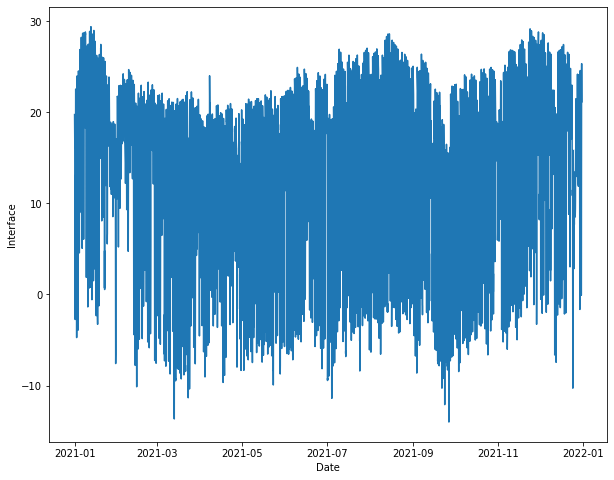

In [35]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
# Interface Data
plt.plot(new_df.index, new_df['Interface'])
plt.xlabel("Date")
plt.ylabel("Interface")

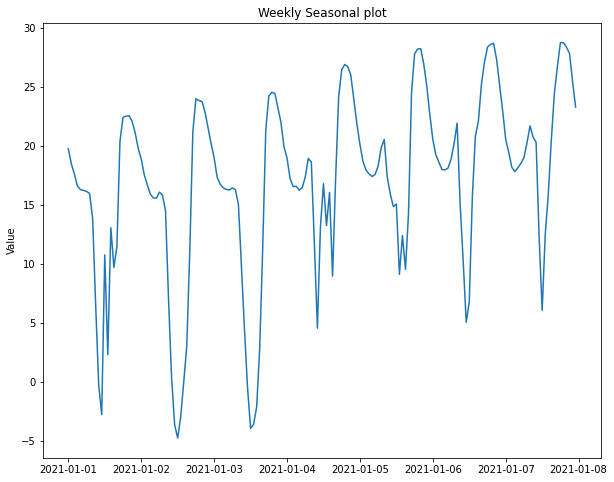

In [36]:
# First week of the year
WEEK_END_INDEX = 7*24
plt.plot(new_df.index[:WEEK_END_INDEX], new_df['Interface'][:WEEK_END_INDEX])
plt.title('Weekly Seasonal plot')
plt.ylabel('Value')
plt.show()

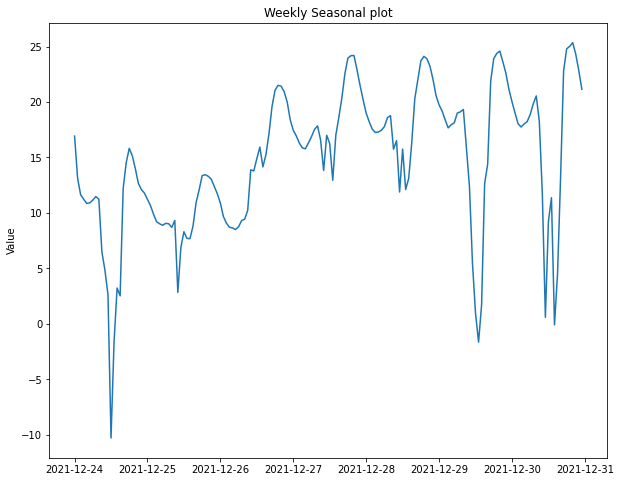

In [37]:
# Last week of the year
WEEK_END_INDEX = 7*24
plt.plot(new_df.index[-WEEK_END_INDEX:], new_df['Interface'][-WEEK_END_INDEX:])
plt.title('Weekly Seasonal plot')
plt.ylabel('Value')
plt.show()

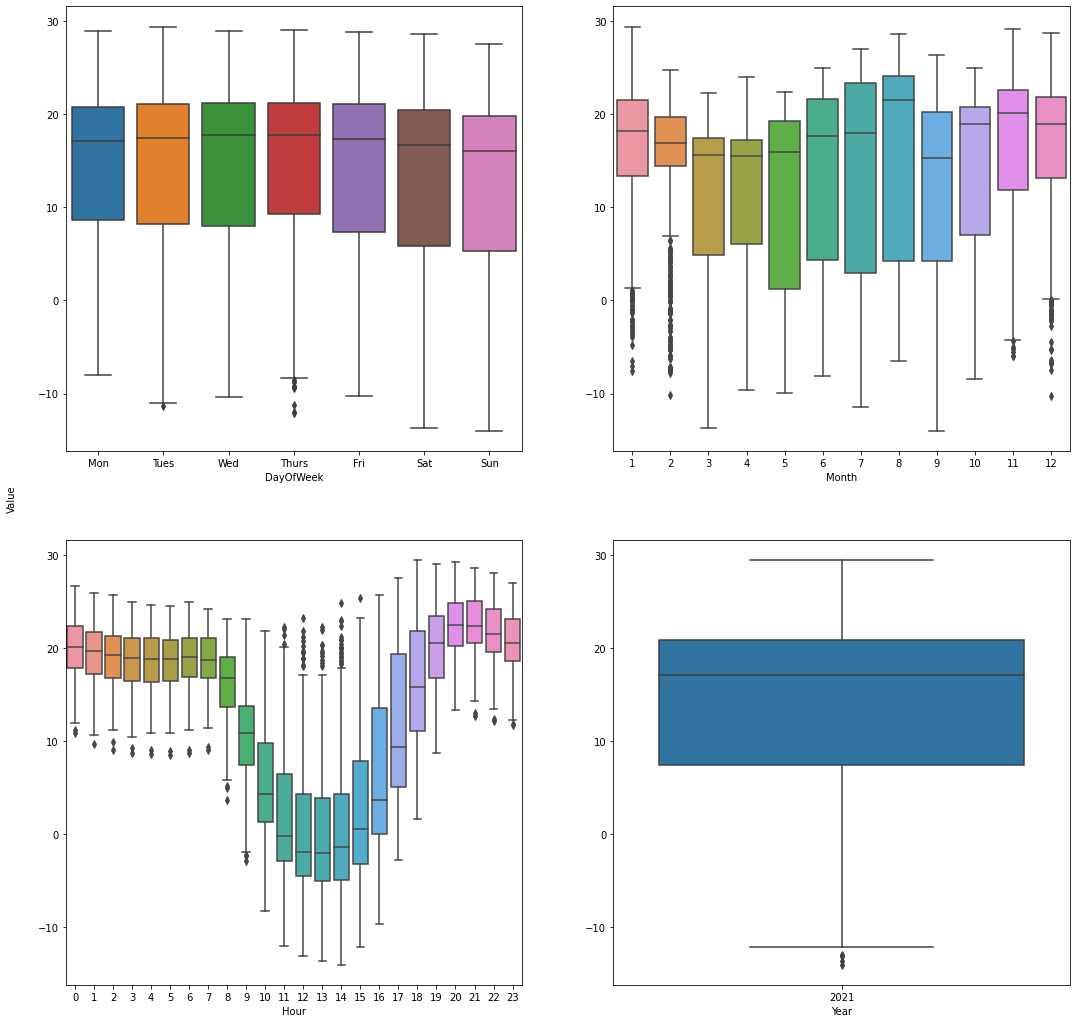

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(18,18))

# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=new_df.DayOfWeek, y=new_df.Interface, ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')

# Month of Year
g = sns.boxplot(x=new_df.Month, y=new_df.Interface, ax=axes[0][1])
g.set_ylabel('')

# Hour of Day
g = sns.boxplot(x=new_df.Hour, y=new_df.Interface, ax=axes[1][0])
g.set_ylabel('')

# Year
g = sns.boxplot(x=new_df.Year, y=new_df.Interface, ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08, 0.5, 'Value', va='center', rotation='vertical')
plt.show()

# Several Outliers in Jan, Feb and Dec (Months with more energy consumption due to the cold/smaller days)
# Major problem -> between Mar and Oct (Much of the generated energy was not used)
# 9h - 18h - Tends to generate too much energy (Energy that isn't used by the costumer - Waste/Costly hours)

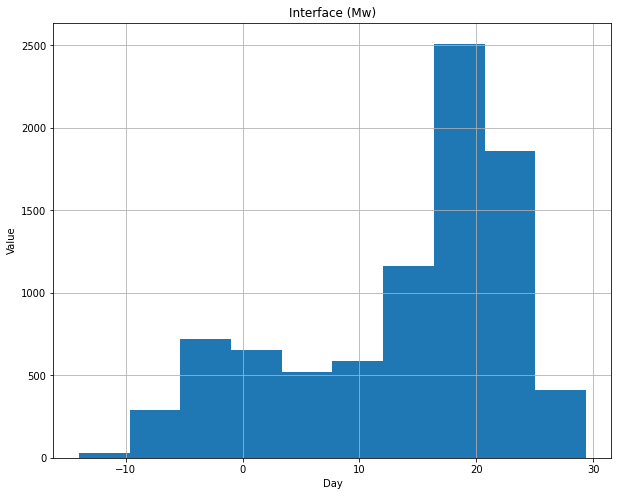

In [39]:
new_df['Interface'].hist()
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Interface (Mw)')
plt.show()

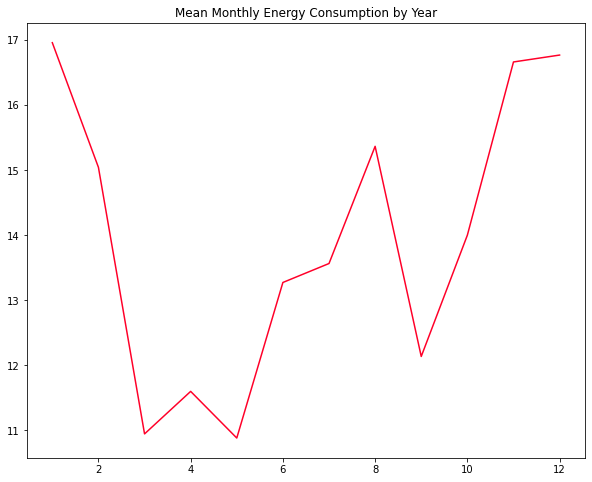

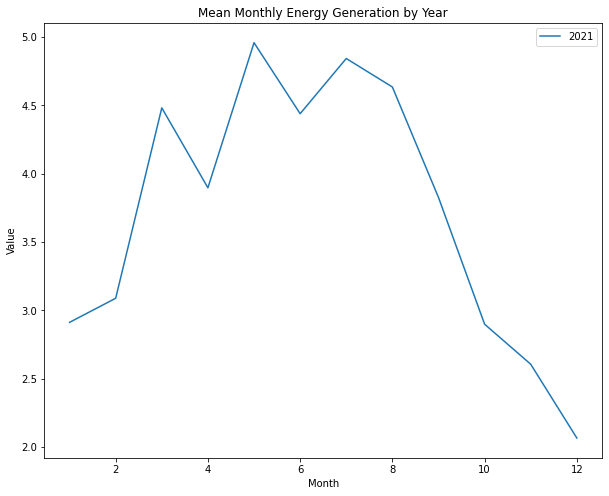

In [40]:
year_group = new_df.groupby(['Year', 'Month']).mean().reset_index()
years = new_df['Year'].unique()
NUM_COLORS = len(years)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    _df = year_group[year_group['Year'] == y]
    plt.title('Mean Monthly Energy Consumption by Year')
    plt.plot(_df['Month'], _df['Interface'])
    plt.show()
    plt.title('Mean Monthly Energy Generation by Year')
    plt.plot(_df['Month'], _df['Local Generation'])
    
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend(new_df.Year.unique())
plt.show()

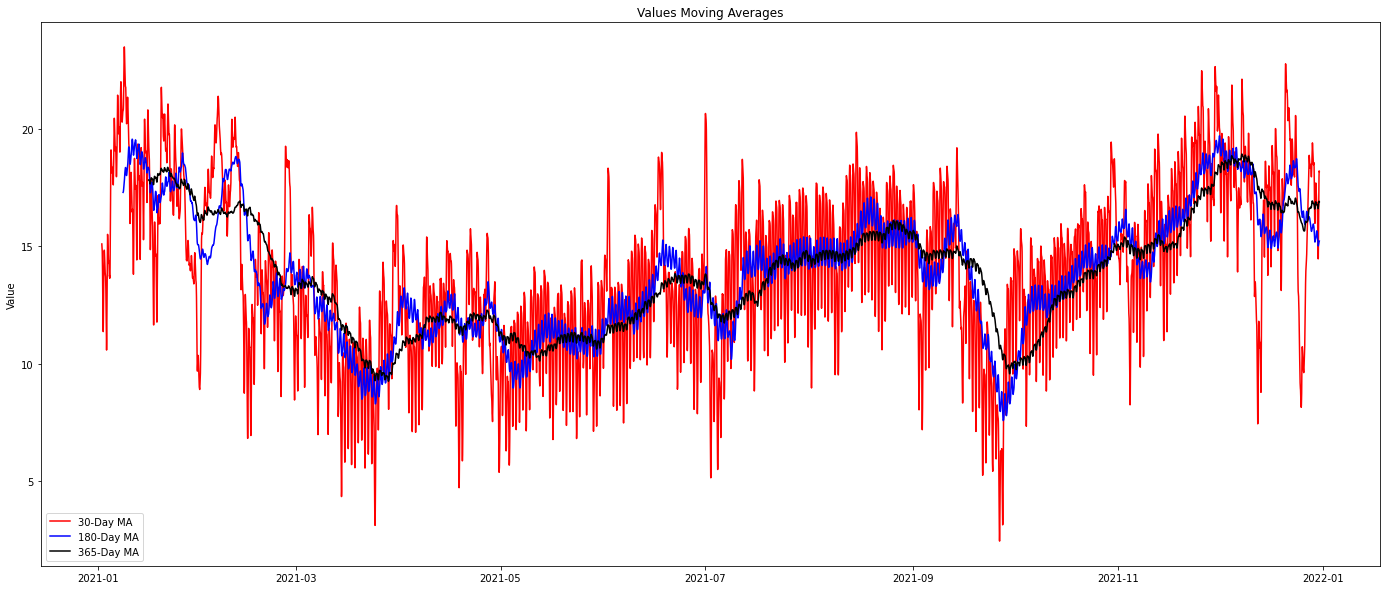

In [41]:
MONTH_PERIOD = 30
MIDYEAR_PERIOD = 182
YEAR_PERIOD = 365

month_roll = new_df['Interface'].rolling(MONTH_PERIOD).mean()
midyear_roll = new_df['Interface'].rolling(MIDYEAR_PERIOD).mean()
year_roll = new_df['Interface'].rolling(YEAR_PERIOD).mean()

fig, ax = plt.subplots(figsize=(24, 10))
plt.plot(month_roll.index, month_roll, color='red', label='30-Day MA')
plt.plot(midyear_roll.index, midyear_roll, color='blue', label='180-Day MA')
plt.plot(year_roll.index, year_roll, color='black', label='365-Day MA')
plt.title('Values Moving Averages')
plt.ylabel('Value')
plt.legend()
plt.show()

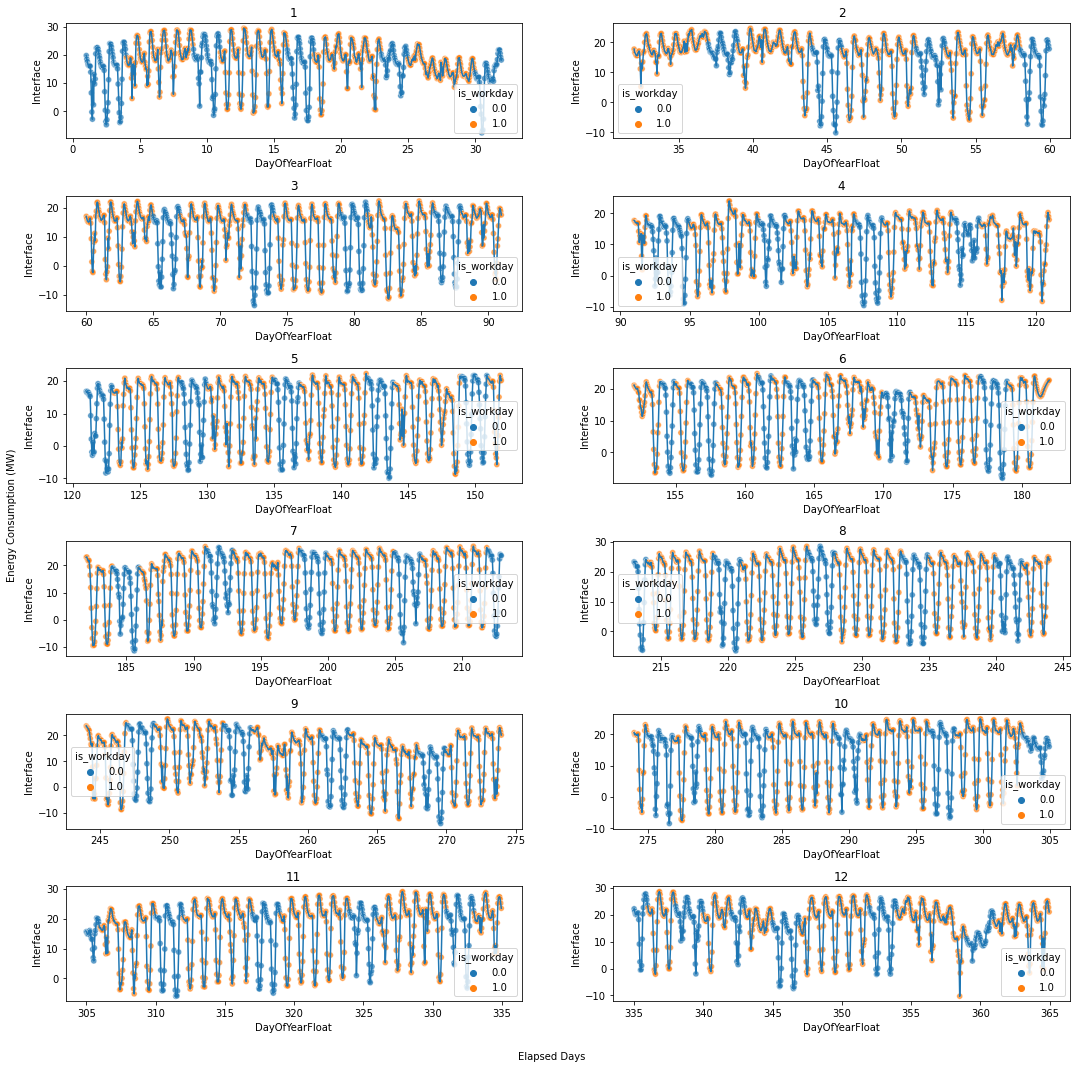

In [42]:
# Monthly Interface Energy Consumption
# Blue color - holidays and weekends
# Orange color - workdays (weekdays that are not holidays)

num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        sns.lineplot(data=df, x='DayOfYearFloat', y='Interface', ax=axes[i,j], palette="flare")
        sns.scatterplot(data=df, x='DayOfYearFloat', y='Interface', alpha=0.7, hue='is_workday', ax=axes[i,j])
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.savefig('images/is_workday_monthly_plot.png')
plt.show()

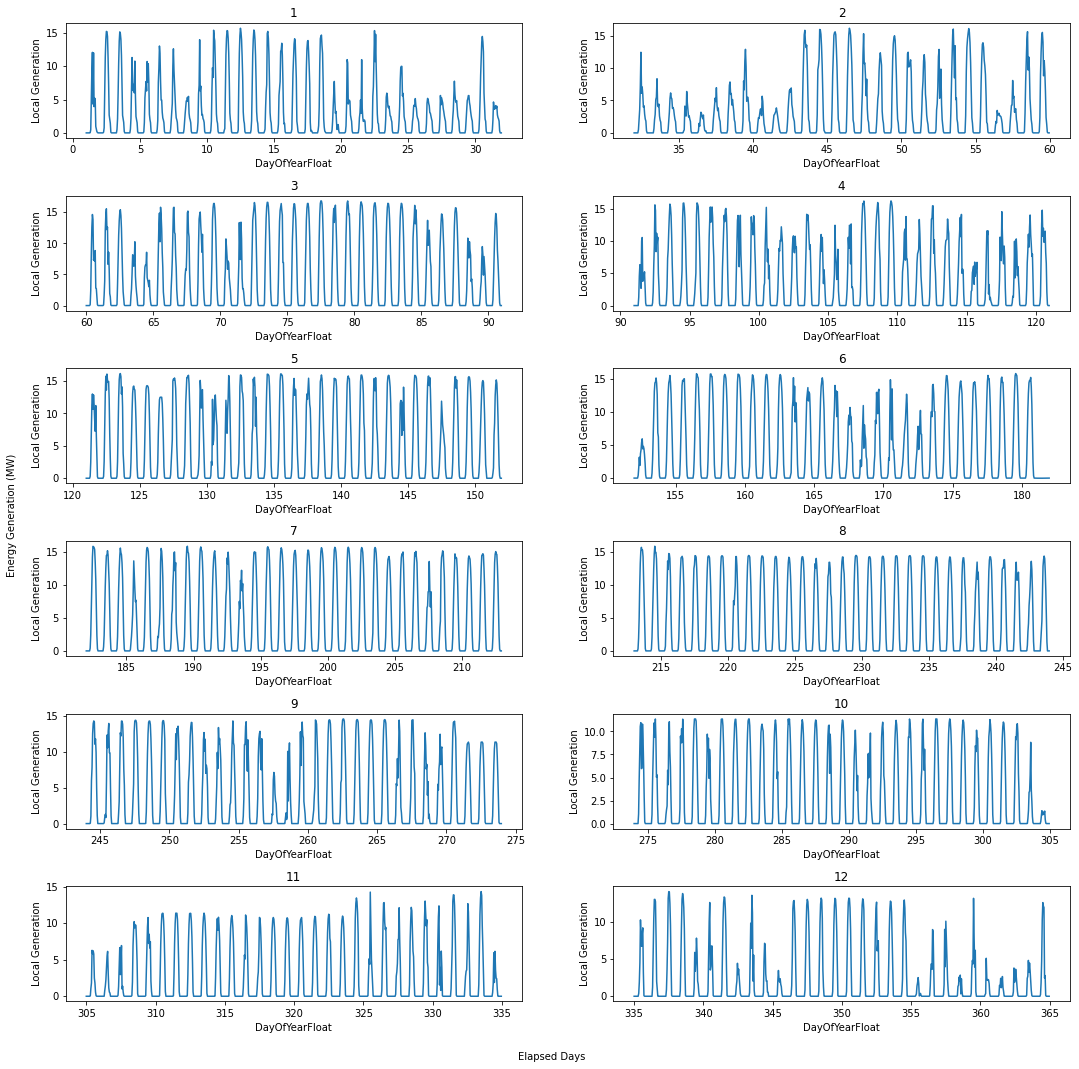

In [43]:
# Local Generation Monthly plot

num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        sns.lineplot(data=df, x='DayOfYearFloat', y='Local Generation', ax=axes[i,j], palette="flare")
#         sns.scatterplot(data=df, x='DayOfYearFloat', y='Local Generation', alpha=0.7, hue='season_of_year', ax=axes[i,j])
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Generation (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

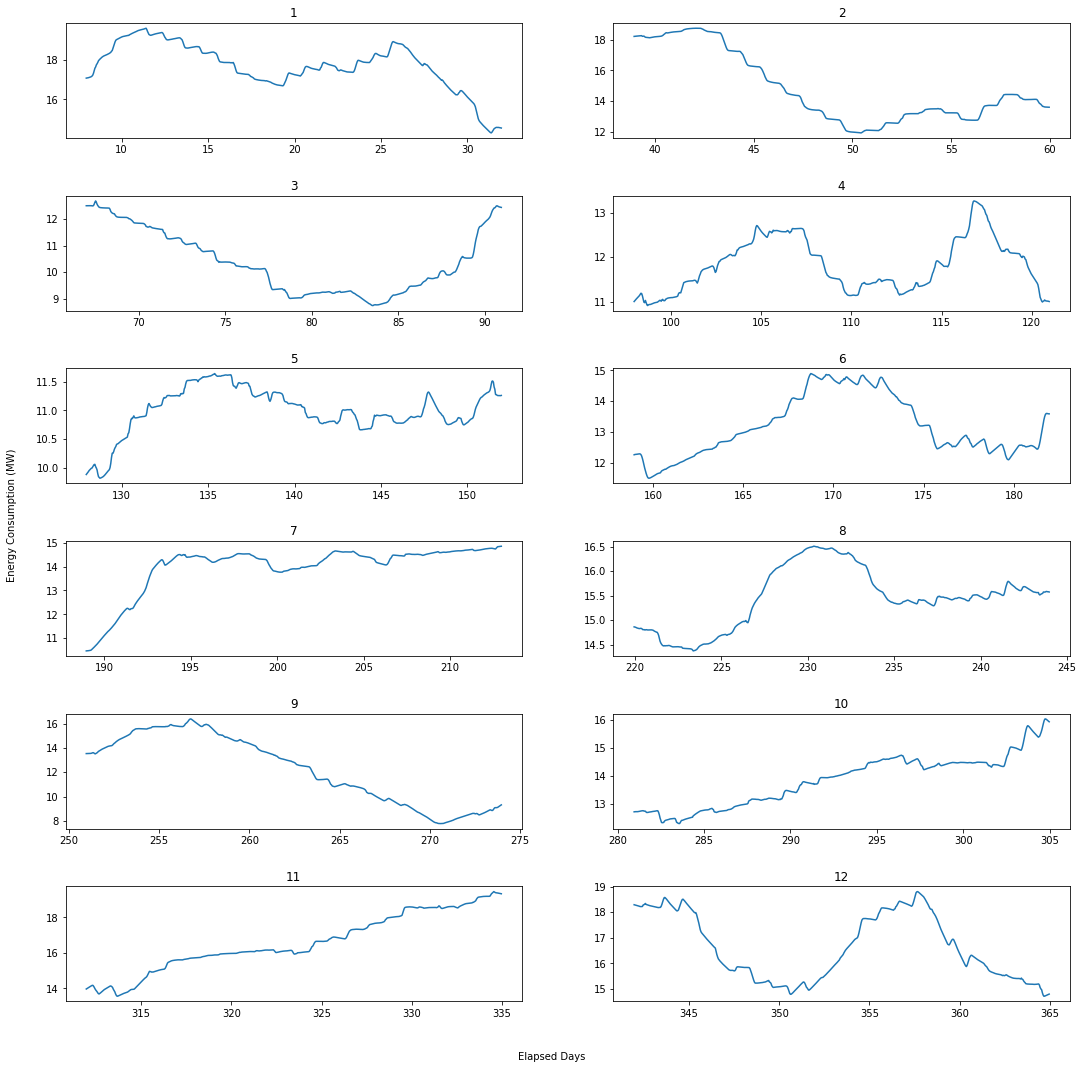

In [44]:
num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        rolling_mean = df['Interface'].rolling(window=7*24).mean()
        axes[i][j].plot(df['DayOfYearFloat'], rolling_mean.values)
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

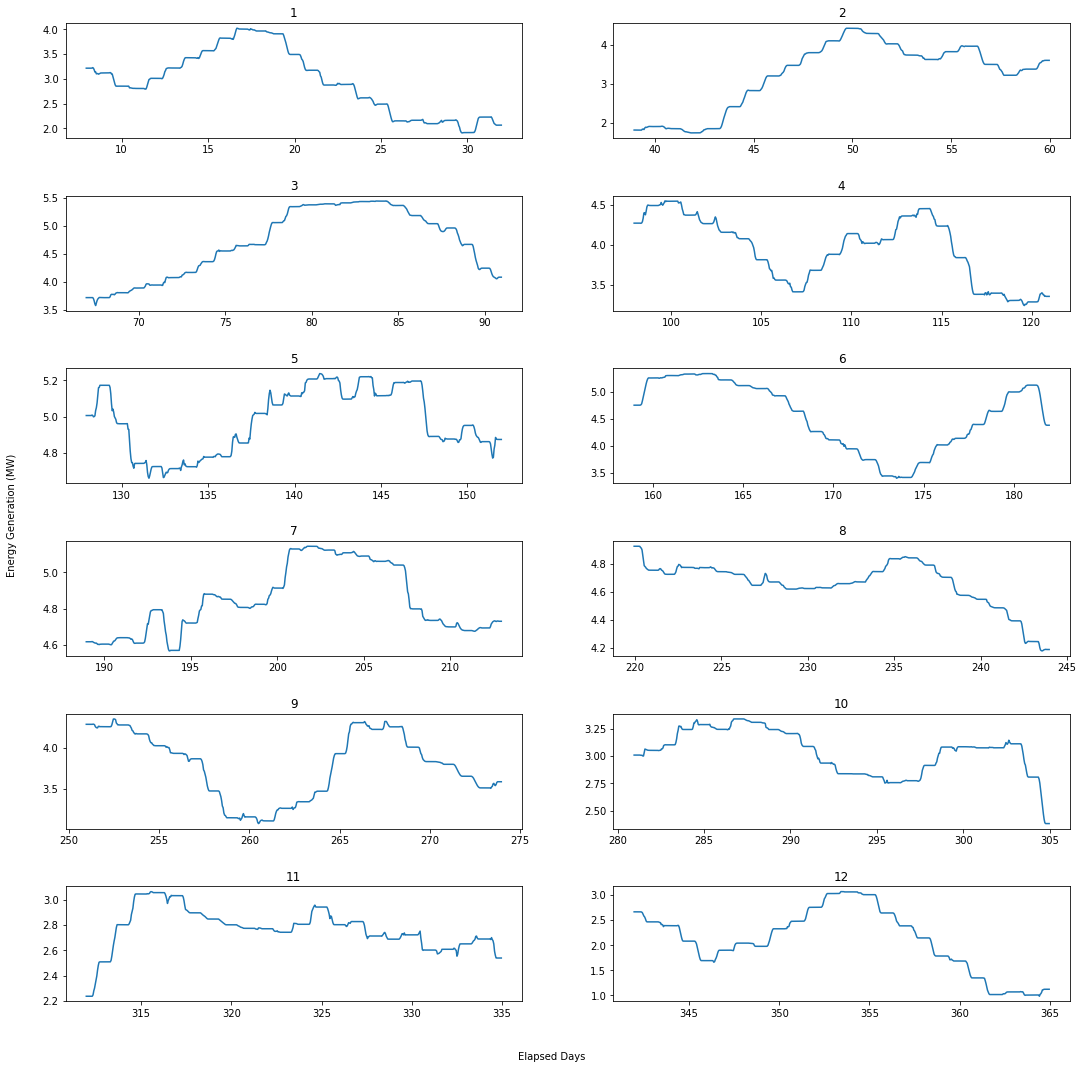

In [45]:
num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        rolling_mean = df['Local Generation'].rolling(window=7*24).mean()
        axes[i][j].plot(df['DayOfYearFloat'], rolling_mean.values)
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Generation (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

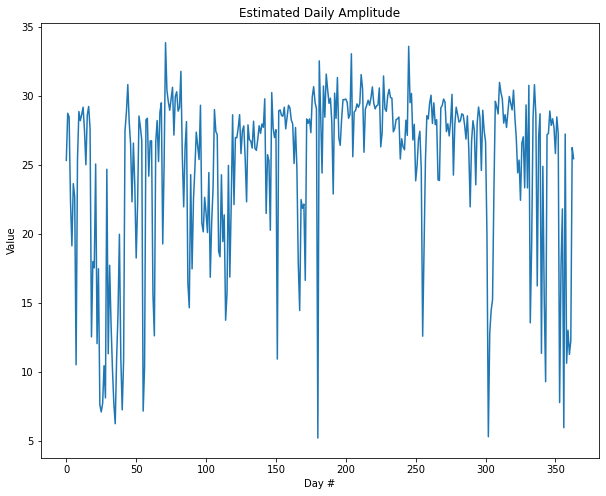

In [46]:
max_daily_vals = new_df.groupby(['Year', 'DayOfYear']).max()['Interface'].values
min_daily_vals = new_df.groupby(['Year', 'DayOfYear']).min()['Interface'].values
daily_amp = max_daily_vals - min_daily_vals
plt.plot(daily_amp)
plt.xlabel('Day #')
plt.ylabel('Value')
plt.title('Estimated Daily Amplitude')
plt.show()

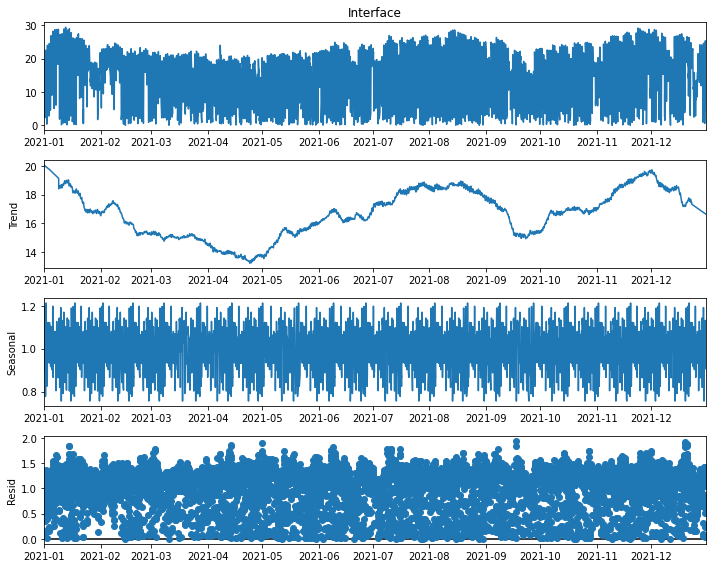

In [47]:
# Seasonal Decomposition

ANNUAL_PERIOD = 365
mult_decomp = seasonal_decompose(new_df[new_df['Interface']>0]['Interface'].dropna(), model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)
mult_decomp.plot()
plt.show()

# Is the series stationary?

In [48]:
adf_result = adfuller(new_df['Interface'], regression='nc') # No trend

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Reject null hypothesis - Time Series has a Unit Root (Not Stationary)

ADF Statistic: -1.6798977648707185
p-value: 0.08798439055354212


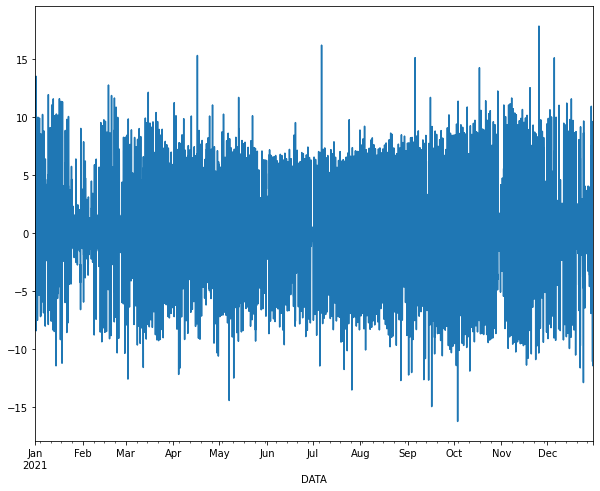

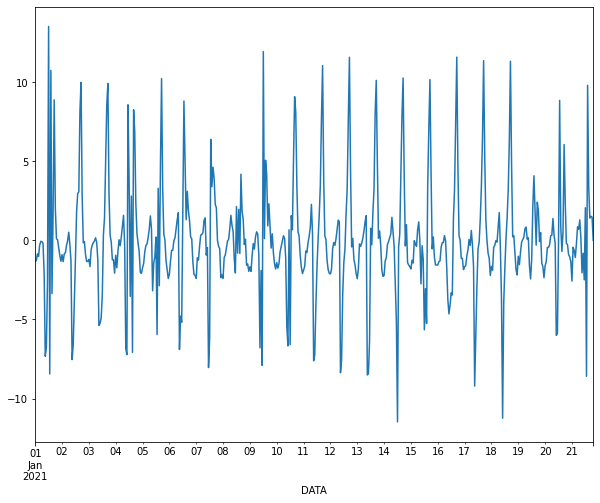

In [49]:
interface_first_difference = new_df['Interface'].diff()
interface_first_difference.plot()
plt.show()

interface_first_difference[:500].plot()
plt.show()

# We still see some seasonality

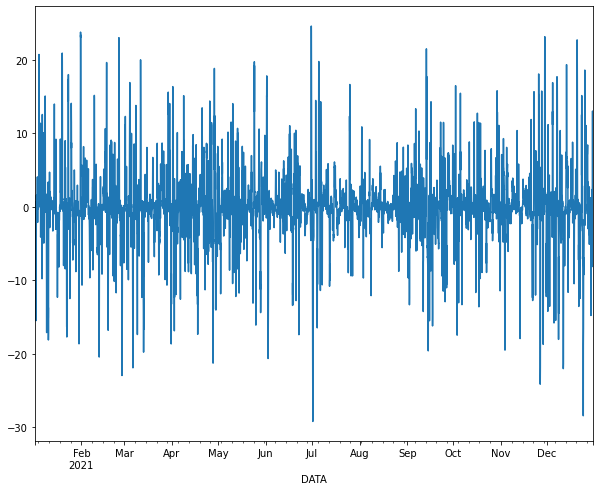

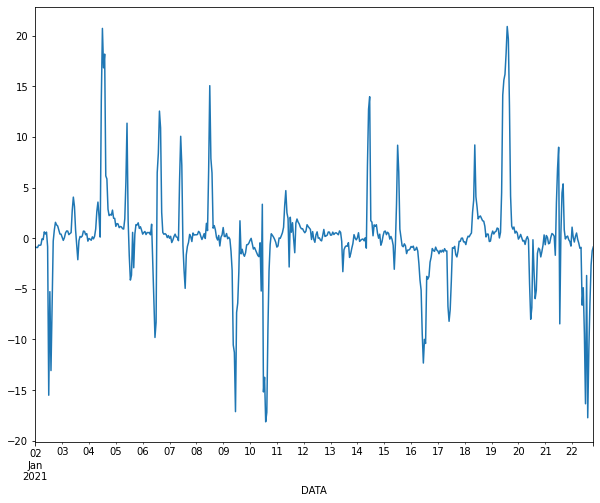

In [50]:
#  Since we are dealing with daily data our period will be 24 hours
test = new_df
test['first_difference'] = test['Interface'].diff(24)
test = test.dropna()
test['first_difference'].plot()
plt.show()

test['first_difference'][:500].plot()
plt.show()

# Hurray! Less Seasonality!

In [51]:
adf_result = adfuller(test['first_difference'], regression='nc')

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# p-val = 3.512418133295498e-29 < 0.05 - First Difference over a 24 hour period is stationary (one day of data)
# This can be an indicator of the m term in Sarima for seasonality

ADF Statistic: -18.860815231789598
p-value: 3.512418133295599e-29


In [52]:
adf_result = adfuller(new_df['Local Generation'], regression='nc')

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Local Generation is Stationary

ADF Statistic: -2.326005111452415
p-value: 0.019276983751921842


<AxesSubplot:xlabel='DATA'>

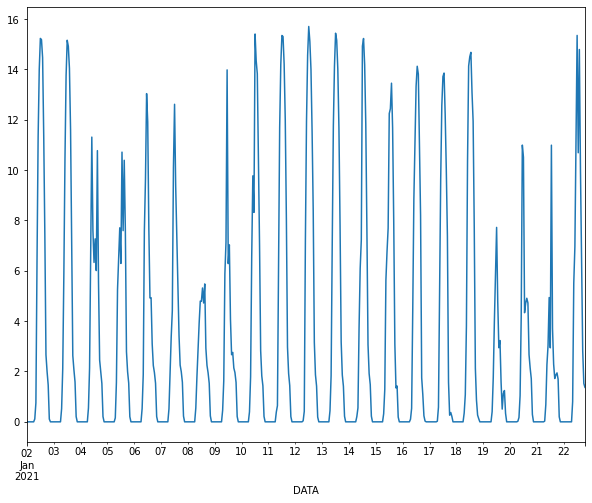

In [53]:
test['Local Generation'][:500].plot()

# Seasonality in the Local Generation time series, let's do the same thing we did with Interface to remove seasonality

<AxesSubplot:xlabel='DATA'>

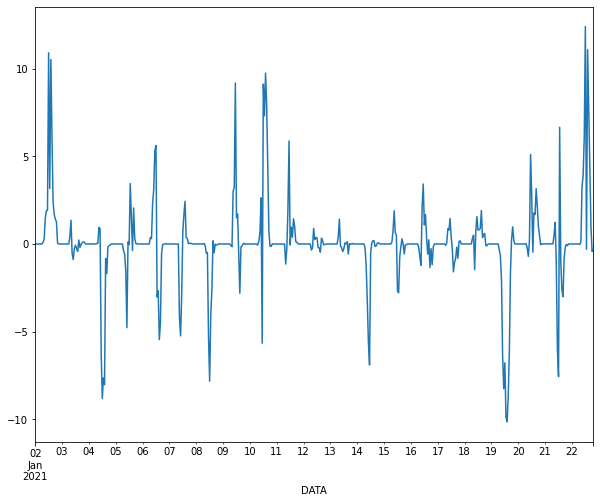

In [54]:
local_gen_first_difference = new_df['Local Generation'].diff(24).dropna()

local_gen_first_difference[:500].plot()

# Removed seasonality - Great news!

In [55]:
test['local_gen_first_difference'] = local_gen_first_difference

In [56]:
adf_result = adfuller(test['local_gen_first_difference'], regression='nc')

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Local Generation first difference also stationary

ADF Statistic: -19.537720334111714
p-value: 0.0


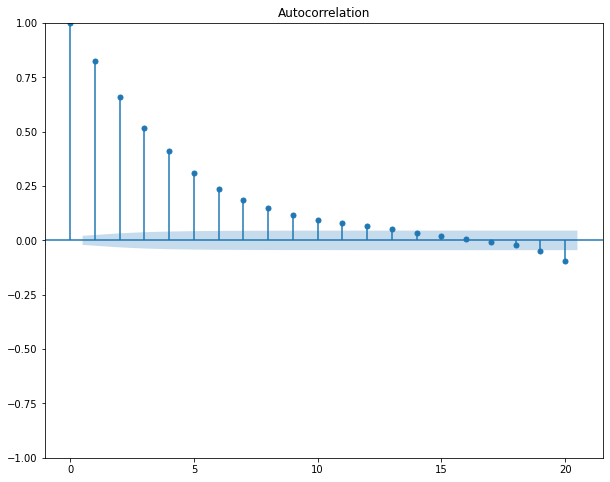

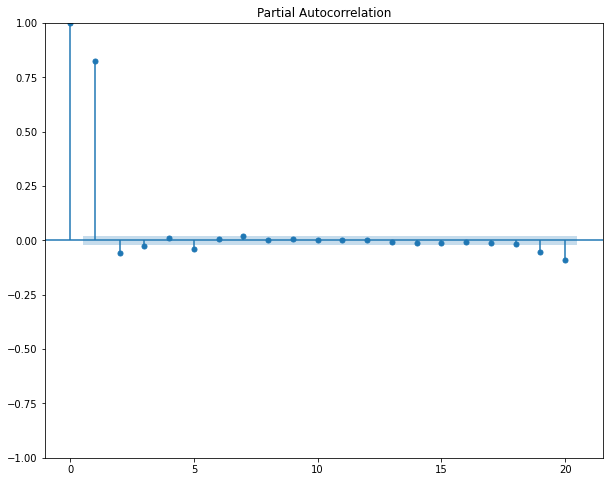

In [57]:
plot_acf(test['first_difference'], lags=20)
plt.show()

plot_pacf(test['first_difference'], lags=20)
plt.show()

# d = 1 - the amount of times we differenciated the series to become stationary (1st order)
# PACF has a peak at lag 1, so it suggests at least 1 AR(1) process, and along with ACF shows
# decreasing trend so no MA process
# and seasonality terms (P,D,Q) - No seasonality seen at 20 lags so let's try (0,0,0)[0]
# Although these plots can give us a general idea of the processes,
# it's nice to choose a model that yield the lowest BIC and AIC (what does autoarima tells us?)

# Granger Causality Test

In [58]:
grangercausalitytests(test[['local_gen_first_difference', 'first_difference']].dropna(), maxlag=5)

# p-val < 0.05 = 0. so Knowing the Local Generation Values is usefull for Energy Consumption prediction.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=62.6134 , p=0.0000  , df_denom=8708, df_num=1
ssr based chi2 test:   chi2=62.6350 , p=0.0000  , df=1
likelihood ratio test: chi2=62.4109 , p=0.0000  , df=1
parameter F test:         F=62.6134 , p=0.0000  , df_denom=8708, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=36.4923 , p=0.0000  , df_denom=8705, df_num=2
ssr based chi2 test:   chi2=73.0264 , p=0.0000  , df=2
likelihood ratio test: chi2=72.7220 , p=0.0000  , df=2
parameter F test:         F=36.4923 , p=0.0000  , df_denom=8705, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=24.6813 , p=0.0000  , df_denom=8702, df_num=3
ssr based chi2 test:   chi2=74.1034 , p=0.0000  , df=3
likelihood ratio test: chi2=73.7899 , p=0.0000  , df=3
parameter F test:         F=24.6813 , p=0.0000  , df_denom=8702, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=18.5846 , p=0.

{1: ({'ssr_ftest': (62.61341127288031, 2.8235194086039172e-15, 8708.0, 1),
   'ssr_chi2test': (62.63498226895503, 2.487948519714782e-15, 1),
   'lrtest': (62.410872749656846, 2.7877985818392248e-15, 1),
   'params_ftest': (62.613411273035034, 2.8235194083847764e-15, 8708.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (36.492256715761165, 1.6507576083860865e-16, 8705.0, 2),
   'ssr_chi2test': (73.02643446163809, 1.3883892428298113e-16, 2),
   'lrtest': (72.72200056644579, 1.6166582412695234e-16, 2),
   'params_ftest': (36.49225671571797, 1.6507576084560168e-16, 8705.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (24.681283991853466, 6.764447336832247e-16, 8702.0, 3),
   'ssr_chi2test': (74.1034137962716, 5.639670150030931e-16, 3),
   'lrtest': (73.78992409677448, 6.583100639245887e-16, 3),
   'params_ftest': (24.681283991949424, 6.764447335879469e-16, 8702.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0.,

In [59]:
data = new_df[['Interface','Local Generation']]

In [60]:
data.head()

,Interface,Local Generation
DATA,,
2021-01-01 00:00:00,19.753853,0.0
2021-01-01 01:00:00,18.472114,0.0
2021-01-01 02:00:00,17.617622,0.0
2021-01-01 03:00:00,16.599771,0.0
2021-01-01 04:00:00,16.298185,0.0


# Part 1 - Fit Autoarima to All Dataset and Examine Residuals

In [61]:
sarima_model_fitted = pmdarima.auto_arima(new_df[['Interface']],
                                        exogenous=new_df[['Local Generation']],
                                        seasonal=True,
                                        start_p=0, start_q=0, d=1, max_q=2, max_p=3, start_P=0, D=1, start_Q=0,
                                        max_P=1, max_Q=1, m=24)

p, d, q = sarima_model_fitted.order
sarima_residuals = sarima_model_fitted.arima_res_.resid

In [62]:
print(sarima_model_fitted)

 ARIMA(0,1,0)(1,1,0)[24]          


In [63]:
sarima_model_fitted.summary()

# Ljung-Box p-val 0.53 > 0.05 - residuals are not auto-correlated
# reject homoskedasticity - the residual series it is not a white noise
# reject normal distribution Jarque Bera test p-val = 0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8736
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 24)   Log Likelihood              -18451.826
Date:                            Sat, 25 Jun 2022   AIC                          36909.653
Time:                                    02:09:45   BIC                          36930.870
Sample:                                01-01-2021   HQIC                         36916.884
                                     - 12-30-2021                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Local Generation    -0.7411      0.008    -96.014      0.000      -0.756      -0.726
ar.S.L24            -0.5988      0.004   -139.006      0.000      -0.607      -0.590
sigma2               4.0444      0.027    152.297      0.000       3.992       4.096
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):             43092.19
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

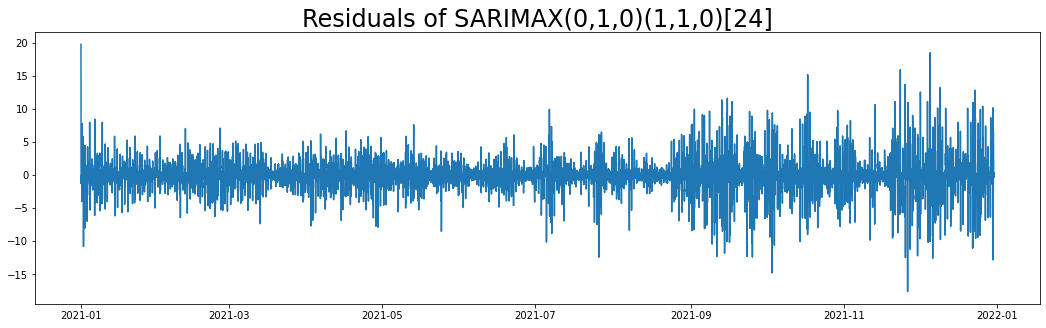

In [64]:
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(sarima_residuals, label = "Residuals")
plt.title("Residuals of SARIMAX(0,1,0)(1,1,0)[24]", size = 24)
plt.savefig(f'{SAVE_DIR}/sarimax_residuals.png')
plt.show()

# several volatility clusters in the residuals

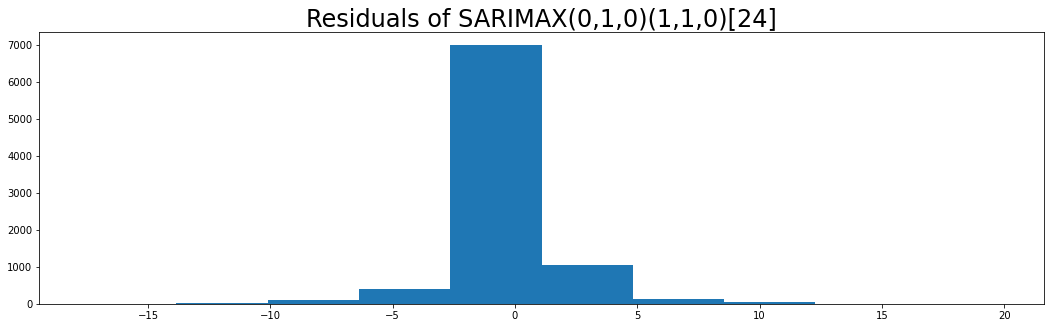

In [65]:
plt.rcParams["figure.figsize"] = 18, 5
plt.hist(sarima_residuals, label = "Residuals")
plt.title("Residuals of SARIMAX(0,1,0)(1,1,0)[24]", size = 24)
plt.show()

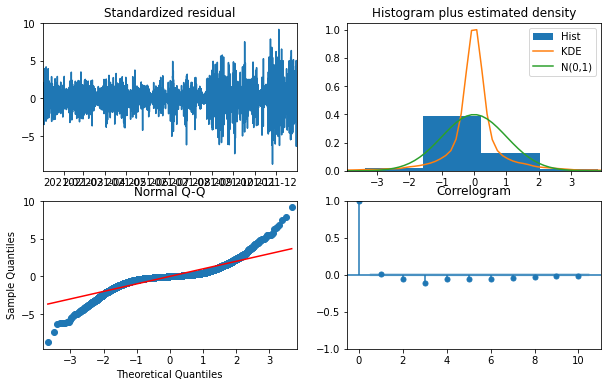

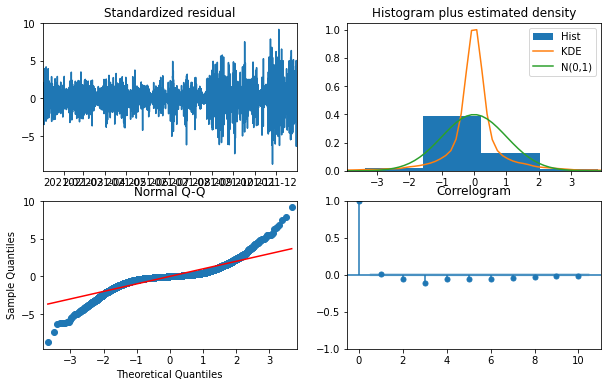

In [66]:
sarima_model_fitted.plot_diagnostics(figsize=(10,6))

In [67]:
# Skewness in the residuals distribution
# Volatility Clusters in the residuals series
# Heteroskedacity in the residuals series

# This said, the model predictions may not be reliable. Thus we need to inspect volatility (Fit a Garch model).

# But let's test Sarimax anyway :D

# Forecast Interface Step by Step - Cross Validation and Autoarima

In [68]:
# Train Test Split
# from 1st January to 30th of November to predict from 1 to 4 of December (72 hours)

train_df = new_df.loc[(new_df.index >= datetime(2021, 1, 1)) & (new_df.index < datetime(2021, 12, 1))][['Interface', 'Local Generation']]
test_df = new_df.loc[(new_df.index >= datetime(2021, 12, 1)) & (new_df.index < datetime(2021, 12, 4))][['Interface', 'Local Generation']]
exogenous_feature_values = list(new_df.loc[(new_df.index >= datetime(2021, 12, 1)) & (new_df.index < datetime(2021, 12, 4))][['Local Generation']].values)

In [69]:
print(train_df.shape, test_df.shape)

(8016, 2) (72, 2)


In [70]:
ar_preds = []
history = [x for x in train_df['Interface'].values]
ex_history = [x for x in train_df[['Local Generation']].values]

for t in range(len(test_df['Interface'].values)):
    model = SARIMAX(history, 
        order=(0,1,0),
        seasonal_order=(1,1,0,24),
        exogenous=ex_history)
    
    model_fit = model.fit()
    output = model_fit.forecast()
    ar_preds.append(output[0])
    history.append(test_df['Interface'].values[t])
    ex_history.append(exogenous_feature_values[t])

ar_pred_series = pd.Series(ar_preds, index=test_df.index)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20627D+00    |proj g|=  2.88214D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.822D-06   2.206D+00
  F =   2.2062553611406268     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20621D+00    |proj g|=  2.88240D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.628D-06   2.206D+00
  F =   2.2061943918696256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20615D+00    |proj g|=  2.88282D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.870D-06   2.206D+00
  F =   2.2061333539923154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.778D-06   2.206D+00
  F =   2.2060719062753607     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20603D+00    |proj g|=  2.88340D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.714D-06   2.206D+00
  F =   2.2060112616635945     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20597D+00    |proj g|=  2.88385D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.780D-06   2.206D+00
  F =   2.2059501971748312     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20590D+00    |proj g|=  2.88422D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.691D-06   2.206D+00
  F =   2.2058887281594952     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20585D+00    |proj g|=  2.88437D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.744D-06   2.206D+00
  F =   2.2058299553961151     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20579D+00    |proj g|=  2.88477D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.814D-06   2.206D+00
  F =   2.2057750492530994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20584D+00    |proj g|=  2.88362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.727D-06   2.206D+00
  F =   2.2058257851524825     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.688D-06   2.207D+00
  F =   2.2065630289409111     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20658D+00    |proj g|=  2.87520D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.688D-06   2.207D+00
  F =   2.2065680435523065     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20653D+00    |proj g|=  2.87633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.746D-06   2.207D+00
  F =   2.2065120344966989     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20649D+00    |proj g|=  2.87736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.794D-06   2.206D+00
  F =   2.2064792153474135     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.072D-06   2.206D+00
  F =   2.2064195467947889     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20761D+00    |proj g|=  2.85805D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.953D-06   2.208D+00
  F =   2.2075937045325853     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20856D+00    |proj g|=  2.84764D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.102D-06   2.209D+00
  F =   2.2085437406069608     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20873D+00    |proj g|=  2.84294D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.781D-06   2.209D+00
  F =   2.2087122440548894     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20872D+00    |proj g|=  2.84199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.044D-06   2.209D+00
  F =   2.2087057326868229     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.755D-06   2.209D+00
  F =   2.2086447965157174     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20860D+00    |proj g|=  2.84251D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.883D-06   2.209D+00
  F =   2.2085851572117816     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20854D+00    |proj g|=  2.84304D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.870D-06   2.209D+00
  F =   2.2085242303381110     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20848D+00    |proj g|=  2.84332D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.953D-06   2.208D+00
  F =   2.2084636233473489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20842D+00    |proj g|=  2.84368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.820D-06   2.208D+00
  F =   2.2084049061527020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.732D-06   2.208D+00
  F =   2.2083436963583374     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20830D+00    |proj g|=  2.84438D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.653D-06   2.208D+00
  F =   2.2082850711718174     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20824D+00    |proj g|=  2.84440D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.679D-06   2.208D+00
  F =   2.2082281084220123     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20819D+00    |proj g|=  2.84490D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.904D-06   2.208D+00
  F =   2.2081737306569416     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20813D+00    |proj g|=  2.84530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.887D-06   2.208D+00
  F =   2.2081124068893443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.791D-06   2.208D+00
  F =   2.2080563577480010     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20801D+00    |proj g|=  2.84591D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.662D-06   2.208D+00
  F =   2.2079974095106305     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20795D+00    |proj g|=  2.84611D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.661D-06   2.208D+00
  F =   2.2079361021798167     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20789D+00    |proj g|=  2.84646D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.755D-06   2.208D+00
  F =   2.2078784581938393     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.805D-06   2.208D+00
  F =   2.2078187098990791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20784D+00    |proj g|=  2.84811D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.934D-06   2.208D+00
  F =   2.2078219663250751     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20778D+00    |proj g|=  2.84865D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.796D-06   2.208D+00
  F =   2.2077682054851455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.892D-06   2.208D+00
  F =   2.2077385071036191     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20775D+00    |proj g|=  2.84792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.776D-06   2.208D+00
  F =   2.2077342493710073     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20773D+00    |proj g|=  2.84762D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.849D-06   2.208D+00
  F =   2.2077122080870573     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20767D+00    |proj g|=  2.84676D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.886D-06   2.208D+00
  F =   2.2076584319772627     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20761D+00    |proj g|=  2.84757D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.827D-06   2.208D+00
  F =   2.2075991040148044     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20786D+00    |proj g|=  2.84078D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.832D-06   2.208D+00
  F =   2.2078451586644965     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.834D-06   2.208D+00
  F =   2.2079476471462756     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20791D+00    |proj g|=  2.83816D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.744D-06   2.208D+00
  F =   2.2078901877963566     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20785D+00    |proj g|=  2.83863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.847D-06   2.208D+00
  F =   2.2078301426705562     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.941D-06   2.208D+00
  F =   2.2077689738130668     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20772D+00    |proj g|=  2.83937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.806D-06   2.208D+00
  F =   2.2077079884453910     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20766D+00    |proj g|=  2.83961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.840D-06   2.208D+00
  F =   2.2076488875629887     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.797D-06   2.208D+00
  F =   2.2075878790824111     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20755D+00    |proj g|=  2.84026D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.774D-06   2.208D+00
  F =   2.2075339427826566     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20749D+00    |proj g|=  2.84044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.065D-06   2.207D+00
  F =   2.2074771294215032     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.859D-06   2.207D+00
  F =   2.2074159791607815     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20737D+00    |proj g|=  2.84121D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.829D-06   2.207D+00
  F =   2.2073549765229621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20731D+00    |proj g|=  2.84162D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.905D-06   2.207D+00
  F =   2.2072938353382057     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20725D+00    |proj g|=  2.84191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.896D-06   2.207D+00
  F =   2.2072348601561171     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.886D-06   2.207D+00
  F =   2.2071737490240313     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20713D+00    |proj g|=  2.84271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.599D-06   2.207D+00
  F =   2.2071193783271590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20710D+00    |proj g|=  2.84293D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.725D-06   2.207D+00
  F =   2.2070860356386888     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20704D+00    |proj g|=  2.84314D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.904D-06   2.207D+00
  F =   2.2070259104749246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.883D-06   2.207D+00
  F =   2.2069779740916062     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20698D+00    |proj g|=  2.84395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.746D-06   2.207D+00
  F =   2.2069611070244801     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.886D-06   2.207D+00
  F =   2.2069035185104919     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20686D+00    |proj g|=  2.84491D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.980D-06   2.207D+00
  F =   2.2068441114656960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20698D+00    |proj g|=  2.84570D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.935D-06   2.207D+00
  F =   2.2069685807052042     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.929D-06   2.207D+00
  F =   2.2069623903806828     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20705D+00    |proj g|=  2.84763D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.164D-06   2.207D+00
  F =   2.2070385524320995     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20706D+00    |proj g|=  2.84858D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.968D-06   2.207D+00
  F =   2.2070453564171646     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20700D+00    |proj g|=  2.84869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.043D-06   2.207D+00
  F =   2.2069851089536248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.010D-06   2.207D+00
  F =   2.2069261451079476     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20688D+00    |proj g|=  2.84948D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.102D-06   2.207D+00
  F =   2.2068654316501948     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20682D+00    |proj g|=  2.84988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.151D-06   2.207D+00
  F =   2.2068044098362138     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.973D-06   2.207D+00
  F =   2.2067440134207179     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


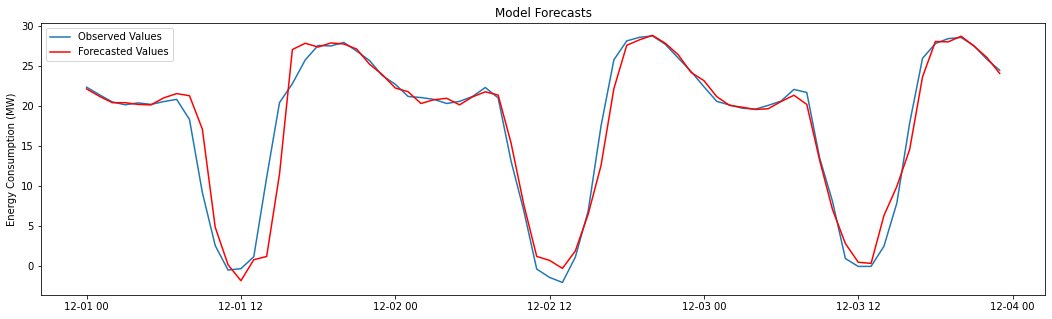

In [71]:
plt.plot(test_df['Interface'], label='Observed Values')
plt.plot(ar_pred_series, color='red', label='Forecasted Values')
plt.legend()
plt.title('Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig('images/Sarimax_forecasting.png')
plt.show()

# Nice results - But it's predicting one point at a time (Not a real n_step forecasting)

In [72]:
rmse = np.sqrt(np.mean(ar_pred_series - test_df['Interface'])**2)
rmse

0.005129587915023887

In [73]:
MAPE = np.mean(np.abs((test_df['Interface'] - ar_pred_series) / test_df['Interface'])) * 100
MAPE

48.426872698947165

# Forecast Without Cross Validation

## According to ACF and PACF

In [74]:
# Our guess about ACF and PACF - p = 1; d = 1; p = 0; P = 0; D = 1; Q = 0; m = 24

sarimax_model = SARIMAX(train_df['Interface'], 
        order=(1, 1, 0),
        seasonal_order=(0,1,0,24),
        exogenous=train_df['Local Generation'])
    
sarimax_model_fit = sarimax_model.fit()
predictions = sarimax_model_fit.forecast(len(test_df))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32959D+00    |proj g|=  5.13750D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      4      1     0     0   1.864D-05   2.330D+00
  F =   2.3295936336534595     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


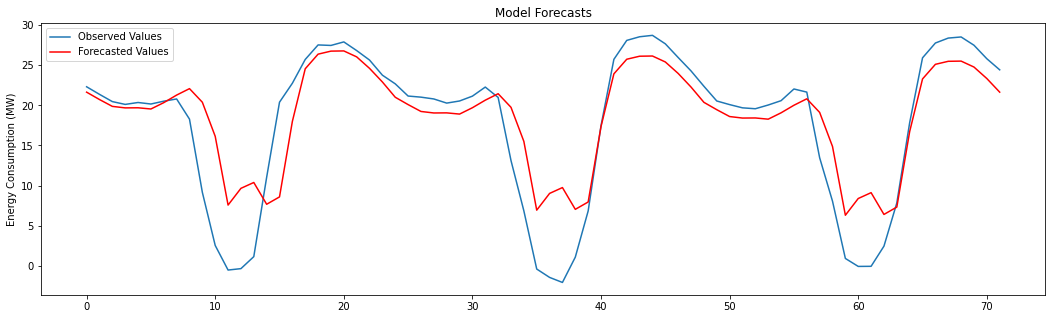

In [75]:
plt.plot(test_df['Interface'].values, label='Observed Values')
plt.plot(np.array(predictions.values), color='red', label='Forecasted Values')
plt.legend()
plt.title('Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig(f'{SAVE_DIR}/sarimax_forecast_autoarima.png')
plt.show()

In [76]:
rmse = np.sqrt(np.mean(predictions.values - test_df['Interface'])**2)
rmse

0.7808151661248162

In [77]:
MAPE = np.mean(np.abs((test_df['Interface'] - predictions.values) / test_df['Interface'])) * 100
MAPE

512.0187517412581

## According to Autoarima

In [78]:
# autoarima forecast guess

# fit autoarima only on train data this time!

#sarima_model_fitted = pmdarima.auto_arima(train_df[['Interface']],
#                                        exogenous=train_df[['Local Generation']],
#                                        seasonal=True,
#                                        start_p=0, start_q=0, d=1, max_q=2, max_p=3, start_P=0, D=1, start_Q=0,
#                                        max_P=1, max_Q=1, m=24)

sarimax_model = SARIMAX(train_df['Interface'], 
        order=(0,1,0),
        seasonal_order=(1,1,0,24),
        exogenous=train_df['Local Generation'])
    
sarimax_model_fit = sarimax_model.fit()
predictions = sarimax_model_fit.forecast(len(test_df))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20627D+00    |proj g|=  2.88214D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.822D-06   2.206D+00
  F =   2.2062553611406268     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


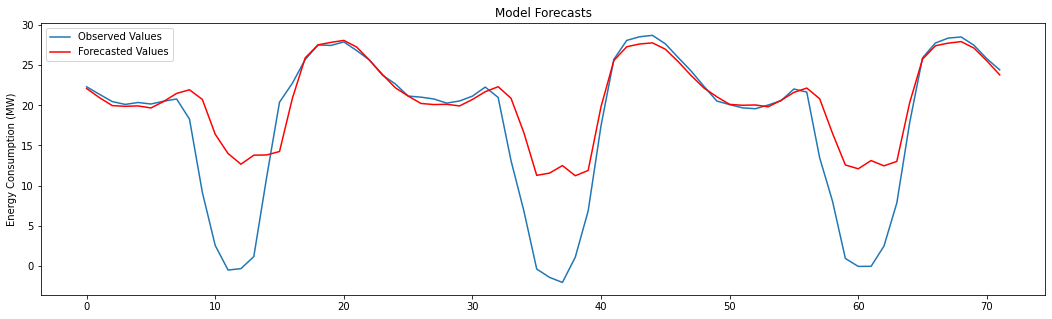

In [79]:
plt.plot(test_df['Interface'].values, label='Observed Values')
plt.plot(predictions.values, color='red', label='Forecasted Values')
plt.legend()
plt.title('Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig(f'{SAVE_DIR}/sarimax_forecast_suggestion.png')
plt.show()

In [80]:
rmse = np.sqrt(np.mean(predictions[:len(test_df)] - test_df['Interface'])**2)
rmse

2.7741086313597383

In [81]:
MAPE = np.mean(np.abs((test_df['Interface'] - predictions.values) / test_df['Interface'])) * 100
MAPE

738.4624165455529

# Let's Inspect Volatility

In [82]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(sarima_residuals, maxlag=50)

print(f'Lagrange multiplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')

# p-val = 0 -> presence of heteroskedasticity in the residuals

Lagrange multiplier p-value: 0.0
F test p-value: 0.0


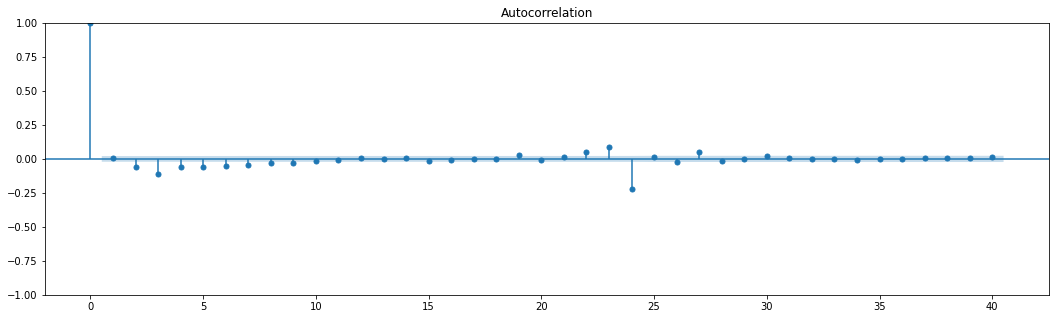

In [83]:
plot_acf(sarima_residuals)
plt.show()

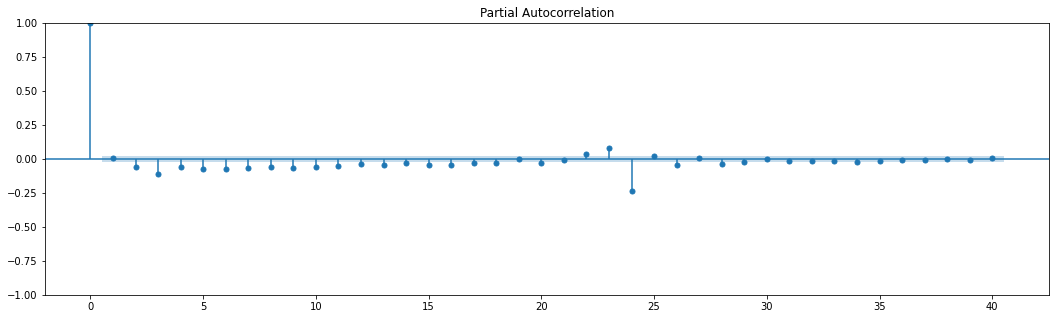

In [84]:
plot_pacf(sarima_residuals)
plt.show()

# Fit Garch Model on Residuals

In [85]:
import arch

garch = arch.arch_model(sarima_residuals, vol='GARCH', p=1, q=1)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 41977.73904892716
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4241253.974073563
Iteration:      3,   Func. Count:     20,   Neg. LLF: 16631.349936706454
Iteration:      4,   Func. Count:     26,   Neg. LLF: 32268.406680948523
Iteration:      5,   Func. Count:     32,   Neg. LLF: 15045623.673017127
Iteration:      6,   Func. Count:     38,   Neg. LLF: 16007.278746843338
Iteration:      7,   Func. Count:     44,   Neg. LLF: 15624.058297302388
Iteration:      8,   Func. Count:     49,   Neg. LLF: 15611.916702703977
Iteration:      9,   Func. Count:     54,   Neg. LLF: 15610.49652263974
Iteration:     10,   Func. Count:     59,   Neg. LLF: 15610.32262790294
Iteration:     11,   Func. Count:     64,   Neg. LLF: 15610.30282875336
Iteration:     12,   Func. Count:     69,   Neg. LLF: 15610.302594189092
Iteration:     13,   Func. Count:     74,   Neg. LLF: 15613.480313801976
Optimization terminated successfully    (Exit mode 0)
  

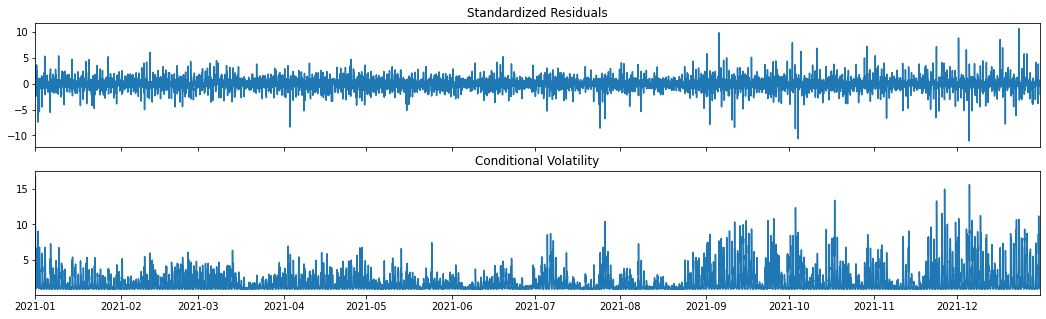

In [86]:
garch_fitted.plot()
plt.savefig(f'{SAVE_DIR}/garch_volatility.png')
plt.show()

[]

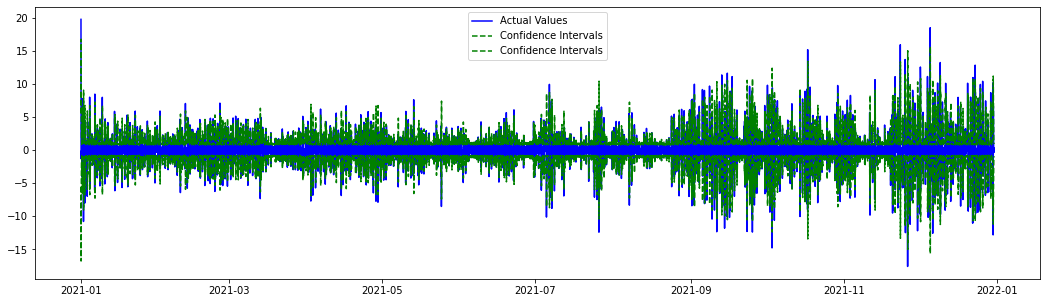

In [87]:
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(sarima_residuals, color = "blue", label = "Actual Values")
plt.plot(garch_fitted.conditional_volatility,color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(-garch_fitted.conditional_volatility,color = "green", linestyle = "--", label = "Confidence Intervals")
plt.legend()
plt.savefig(f'{SAVE_DIR}/garch_and_series.png')
plt.plot()

# Part 2 - Recurrent Neural Networks Fit

# Train Test Split

In [88]:
BEGIN_TRAIN_DATE = datetime(2021, 1, 1)
END_TRAIN_DATE = datetime(2021, 12, 1)
BEGIN_TEST_DATE = datetime(2021, 12, 1)
END_TEST_DATE = datetime(2021, 12, 14)
BEGIN_FORECAST_DATE = datetime(2021, 12, 14)
END_FORECAST_DATE = datetime(2021, 12, 31)

train_df = new_df.loc[(new_df.index >= BEGIN_TRAIN_DATE) & (new_df.index < END_TRAIN_DATE)][['Interface', 'Local Generation', 'is_workday', 'season_of_year']]
train_series_data = new_df.loc[(new_df.index >= BEGIN_TRAIN_DATE) & (new_df.index < END_TRAIN_DATE)][['Interface', 'Local Generation']]

test_df = new_df.loc[(new_df.index >= BEGIN_TEST_DATE) & (new_df.index < END_TEST_DATE)][['Interface', 'Local Generation', 'is_workday', 'season_of_year']]
test_series_data = new_df.loc[(new_df.index >= BEGIN_TEST_DATE) & (new_df.index < END_TEST_DATE)][['Interface', 'Local Generation']]

plot_df = new_df.loc[(new_df.index >= BEGIN_TEST_DATE) & (new_df.index < END_TEST_DATE)][['Interface']]

forecast_data = new_df.loc[(new_df.index >= BEGIN_FORECAST_DATE) & (new_df.index < END_FORECAST_DATE)][['Interface', 'Local Generation', 'is_workday', 'season_of_year']]



In [89]:
garch_pred_volatility = np.array([garch_fitted.conditional_volatility]).reshape(-1,1)
train_volatility_garch = garch_pred_volatility[0: len(train_df), :]
test_volatility_garch = garch_pred_volatility[len(train_df):len(train_df)+len(test_df), :]
forecast_volatility_garch = garch_pred_volatility[len(train_df)+len(test_df):len(train_df)+len(test_df)+len(forecast_data), :]

print(train_volatility_garch.shape, test_volatility_garch.shape, forecast_volatility_garch.shape)


(8016, 1) (312, 1) (408, 1)


In [90]:
# Append 'is workday' and 'season_of_year' to volatility data - [volatility, is_workday, seaso_of_year]
train_volatility_garch = np.column_stack((train_volatility_garch,train_df['is_workday'].values,train_df['season_of_year'].values))
test_volatility_garch = np.column_stack((test_volatility_garch, test_df['is_workday'].values,test_df['season_of_year'].values))
forecast_volatility_garch = np.column_stack((forecast_volatility_garch, forecast_data['is_workday'].values, forecast_data['season_of_year'].values))


# Scale Data

In [91]:
scaler_1 = MinMaxScaler(feature_range=(0,1))
scaler_1.fit(train_volatility_garch)

garch_train_scaled_data = scaler_1.transform(train_volatility_garch)
garch_test_scaled_data = scaler_1.transform(test_volatility_garch)
garch_forecast_scaled_data = scaler_1.transform(forecast_volatility_garch)

In [92]:
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_2.fit(train_df)

train_scaled_data = scaler_2.transform(train_df)
test_scaled_data = scaler_2.transform(test_df)
forecast_scaled_data = scaler_2.transform(forecast_data)

In [93]:
scaler_3 = MinMaxScaler(feature_range=(0,1))
scaler_3.fit(train_series_data)

train_series_scaled_data = scaler_3.transform(train_series_data)
test_series_scaled_data = scaler_3.transform(test_series_data)
forecast_series_scaled_data = scaler_3.transform(forecast_data[['Interface','Local Generation']].values)

# Create Sequences

In [94]:
def create_sequences(scaled_data, offset=168):
    # offset = Last 168 hours -> 7 days sequences
    
    num_features = scaled_data.shape[1]
    x = []
    y = []
    
    for i in range(offset, len(scaled_data)):
        x.append(scaled_data[i-offset:i,0:num_features])
        y.append(scaled_data[i,0])

    x = np.array(x)
    y = np.array(y).reshape(-1,1)
    
    return x, y

In [95]:
x_train, y_train = create_sequences(train_scaled_data)
x_test, y_test = create_sequences(test_scaled_data)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(7848, 168, 4) (144, 168, 4)
(7848, 1) (144, 1)


In [96]:
x_train_garch, _ = create_sequences(garch_train_scaled_data)
x_test_garch, _ = create_sequences(garch_test_scaled_data)

print(x_train_garch.shape, x_test_garch.shape)

(7848, 168, 3) (144, 168, 3)


In [97]:
x_train_series, _ = create_sequences(train_series_scaled_data)
x_test_series, _ = create_sequences(test_series_scaled_data)

print(x_train_series.shape, x_test_series.shape)

(7848, 168, 2) (144, 168, 2)


In [98]:
forecast_volatility, _ = create_sequences(garch_forecast_scaled_data)
forecast_data_, _ = create_sequences(forecast_scaled_data)
forecast_series_data, _ = create_sequences(forecast_series_scaled_data)

print(forecast_volatility.shape, forecast_data_.shape, forecast_series_data.shape)

(240, 168, 3) (240, 168, 4) (240, 168, 2)


In [99]:
# All Set and Ready to go!!

# Simple LSTM

In [100]:
model_1_input = Input(shape=(x_train.shape[1], x_train.shape[2]))

lstm_layer_1 = LSTM(100, return_sequences=True, dropout=0.2)(model_1_input)
lstm_layer_2 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_1)
lstm_layer_3 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_2)
lstm_layer_4 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_3)
lstm_layer_5 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_4)
lstm_layer_6 = LSTM(100, dropout=0.2)(lstm_layer_5)

dense_1 = Dense(512, activation='relu')(lstm_layer_6)
dpout_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(256, activation='relu')(dpout_1)
dpout_2 = Dropout(0.2)(dense_2)

output_layer = Dense(1, activation='linear')(dpout_2)

model_lstm = Model(inputs=model_1_input, outputs=output_layer)

Metal device set to: Apple M1


2022-06-25 02:12:39.009686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-25 02:12:39.010632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [101]:
model_lstm.compile(optimizer=SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mse'])

In [102]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", 
                                        patience = 10,
                                        restore_best_weights = True)

In [103]:
hist = model_lstm.fit(x_train, y_train,
            batch_size = 32,
            epochs = 100,
            callbacks=[earlystopping],
            validation_data=(x_test, y_test))

Epoch 1/100


2022-06-25 02:12:40.072484: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-25 02:12:43.531683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:12:44.107055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:12:44.366228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:12:44.586767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:12:44.809119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:12:45.030820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

246/246 [==============================] - ETA: 0s - loss: 0.0302 - mse: 0.0605

2022-06-25 02:13:38.566272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:13:38.761255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:13:38.977605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:13:39.193364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:13:39.411765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:13:39.635731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 02:13:39.853815: I tensorflow/core/grappler/optimizers/cust

246/246 [==============================] - 62s 215ms/step - loss: 0.0302 - mse: 0.0605 - val_loss: 0.0179 - val_mse: 0.0358
Epoch 2/100
246/246 [==============================] - 46s 188ms/step - loss: 0.0244 - mse: 0.0487 - val_loss: 0.0183 - val_mse: 0.0367
Epoch 3/100
246/246 [==============================] - 47s 190ms/step - loss: 0.0241 - mse: 0.0481 - val_loss: 0.0169 - val_mse: 0.0337
Epoch 4/100
246/246 [==============================] - 47s 193ms/step - loss: 0.0239 - mse: 0.0478 - val_loss: 0.0172 - val_mse: 0.0344
Epoch 5/100
246/246 [==============================] - 47s 192ms/step - loss: 0.0232 - mse: 0.0464 - val_loss: 0.0165 - val_mse: 0.0330
Epoch 6/100
246/246 [==============================] - 48s 193ms/step - loss: 0.0218 - mse: 0.0436 - val_loss: 0.0164 - val_mse: 0.0327
Epoch 7/100
246/246 [==============================] - 47s 190ms/step - loss: 0.0196 - mse: 0.0392 - val_loss: 0.0167 - val_mse: 0.0333
Epoch 8/100
246/246 [==============================] - 48s 1

Epoch 61/100
246/246 [==============================] - 52s 211ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0067 - val_mse: 0.0135
Epoch 62/100
246/246 [==============================] - 52s 212ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0070 - val_mse: 0.0140
Epoch 63/100
246/246 [==============================] - 52s 212ms/step - loss: 0.0037 - mse: 0.0075 - val_loss: 0.0066 - val_mse: 0.0133
Epoch 64/100
246/246 [==============================] - 52s 212ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0071 - val_mse: 0.0142
Epoch 65/100
246/246 [==============================] - 52s 212ms/step - loss: 0.0037 - mse: 0.0073 - val_loss: 0.0068 - val_mse: 0.0136
Epoch 66/100
246/246 [==============================] - 52s 210ms/step - loss: 0.0037 - mse: 0.0073 - val_loss: 0.0066 - val_mse: 0.0132
Epoch 67/100
246/246 [==============================] - 51s 209ms/step - loss: 0.0037 - mse: 0.0075 - val_loss: 0.0067 - val_mse: 0.0134
Epoch 68/100
246/246 [===================

In [104]:
y_pred = model_lstm.predict(x_test)

2022-06-25 04:44:34.814703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:35.000047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:35.219275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:35.439351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:35.663661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:35.887760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:36.112274: I tensorflow/core/grappler/optimizers/cust

In [105]:
y_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler.fit(train_df['Interface'].values.reshape(-1,1))

MinMaxScaler()

In [106]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

0.020699602207832346

In [107]:
y_pred = y_scaler.inverse_transform(y_pred)

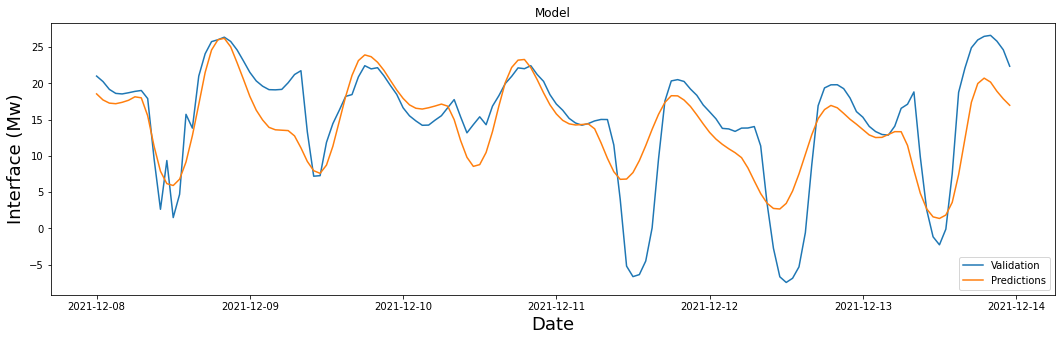

In [108]:
# Plot the data
interface_data = plot_df.filter(['Interface'])
valid = interface_data[-x_test.shape[0]:]
valid['Predictions'] = y_pred

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.plot(valid[['Interface', 'Predictions']])
plt.legend(['Validation', 'Predictions'], loc='lower right')
plt.savefig(f'{SAVE_DIR}/lstm_forecast.png')
plt.show()

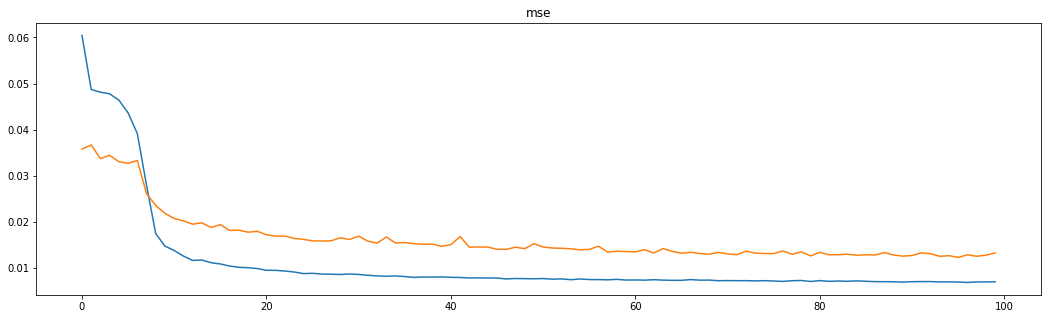

In [109]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('mse')
plt.savefig(f'{SAVE_DIR}/lstm_mse.png')
plt.show()

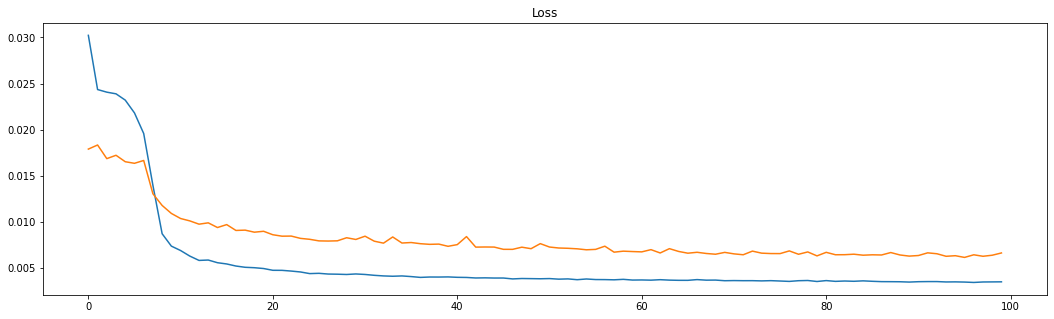

In [110]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.savefig(f'{SAVE_DIR}/lstm_loss.png')
plt.show()

In [111]:
rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Interface'])**2)
rmse

0.8986891596211818

In [112]:
MAPE = np.mean(np.abs((valid['Interface'] - valid['Predictions']) / valid['Interface'])) * 100
MAPE

187.3660248627454

# Bidirecional LSTM

In [113]:
model_1_input = Input(shape=(x_train.shape[1], x_train.shape[2]))

lstm_layer_1 = LSTM(100, return_sequences=True, dropout=0.2)(model_1_input)
lstm_layer_2 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_1)

bidirectional_layer_1 = Bidirectional(LSTM(100, dropout=0.2, return_sequences=True, recurrent_dropout=0))(lstm_layer_2)
bidirectional_layer_2 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0))(bidirectional_layer_1)

dense_1 = Dense(512, activation='relu')(bidirectional_layer_2)
dpout_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(256, activation='relu')(dpout_1)
dpout_2 = Dropout(0.2)(dense_2)

output_layer = Dense(1, activation='linear')(dpout_2)

model_bi_lstm = Model(inputs=model_1_input, outputs=output_layer)

In [114]:
model_bi_lstm.compile(optimizer=SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mse'])

In [115]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", 
                                        patience = 10, 
                                        restore_best_weights = True)

In [116]:
hist = model_bi_lstm.fit(x_train, y_train,
        batch_size = 32, 
        epochs = 100,
        callbacks=[earlystopping],
        validation_data=(x_test, y_test))

Epoch 1/100


2022-06-25 04:44:42.549412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:43.123984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:43.365617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:43.601652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:43.612807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:43.977522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:44:43.989983: I tensorflow/core/grappler/optimizers/cust

246/246 [==============================] - ETA: 0s - loss: 0.0299 - mse: 0.0597

2022-06-25 04:45:43.888528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:45:44.097429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:45:44.317325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:45:44.575765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:45:44.583842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:45:44.947521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 04:45:44.955909: I tensorflow/core/grappler/optimizers/cust

246/246 [==============================] - 68s 244ms/step - loss: 0.0299 - mse: 0.0597 - val_loss: 0.0170 - val_mse: 0.0341
Epoch 2/100
246/246 [==============================] - 54s 218ms/step - loss: 0.0216 - mse: 0.0432 - val_loss: 0.0147 - val_mse: 0.0293
Epoch 3/100
246/246 [==============================] - 55s 225ms/step - loss: 0.0150 - mse: 0.0300 - val_loss: 0.0123 - val_mse: 0.0246
Epoch 4/100
246/246 [==============================] - 55s 222ms/step - loss: 0.0096 - mse: 0.0192 - val_loss: 0.0114 - val_mse: 0.0227
Epoch 5/100
246/246 [==============================] - 55s 222ms/step - loss: 0.0075 - mse: 0.0149 - val_loss: 0.0114 - val_mse: 0.0229
Epoch 6/100
246/246 [==============================] - 55s 223ms/step - loss: 0.0066 - mse: 0.0131 - val_loss: 0.0114 - val_mse: 0.0229
Epoch 7/100
246/246 [==============================] - 55s 224ms/step - loss: 0.0060 - mse: 0.0120 - val_loss: 0.0108 - val_mse: 0.0215
Epoch 8/100
246/246 [==============================] - 55s 2

In [117]:
y_pred = model_bi_lstm.predict(x_test)

2022-06-25 05:21:56.475809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 05:21:56.661569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 05:21:56.894883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 05:21:57.122454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 05:21:57.130751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 05:21:57.505168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 05:21:57.513583: I tensorflow/core/grappler/optimizers/cust

In [118]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

0.009890920412580693

In [119]:
y_pred = y_scaler.inverse_transform(y_pred)

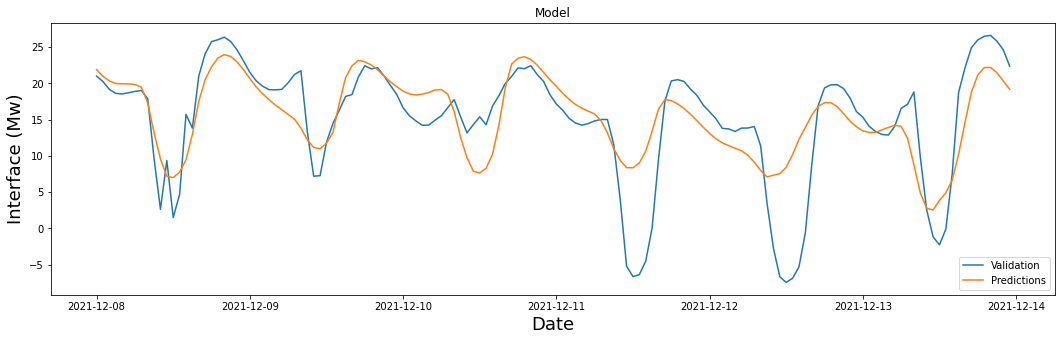

In [120]:
# Plot the data
interface_data = plot_df.filter(['Interface'])
valid = interface_data[-x_test.shape[0]:]
valid['Predictions'] = y_pred

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.plot(valid[['Interface', 'Predictions']])
plt.legend(['Validation', 'Predictions'], loc='lower right')
plt.savefig(f'{SAVE_DIR}/bi_lstm_forecast.png')
plt.show()

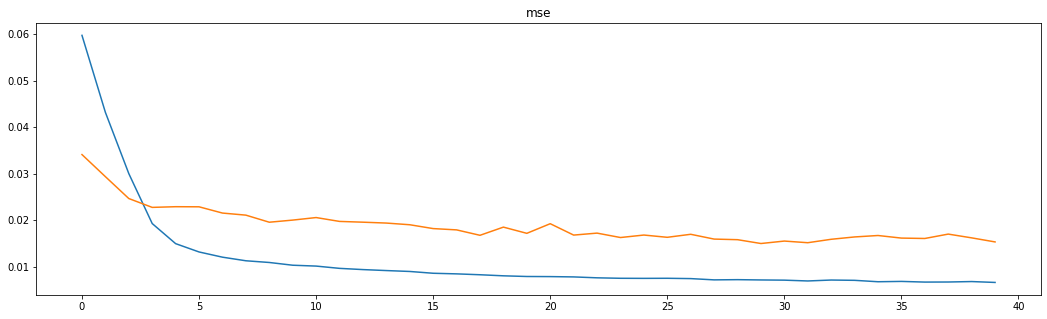

In [121]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('mse')
plt.savefig(f'{SAVE_DIR}/bi_lstm_mse.png')
plt.show()

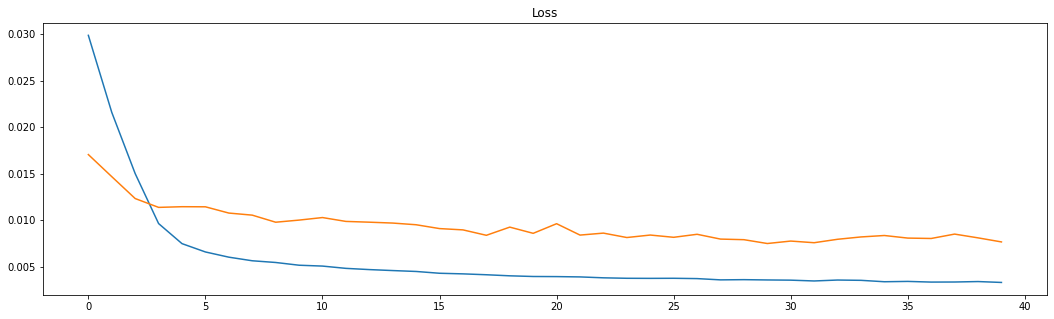

In [122]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.savefig(f'{SAVE_DIR}/bi_lstm_loss.png')
plt.show()

In [123]:
rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Interface'])**2)
rmse

0.429421365556403

In [124]:
MAPE = np.mean(np.abs((valid['Interface'] - valid['Predictions']) / valid['Interface'])) * 100
MAPE

216.8350633374995

# Part 3 - Stack Convolutional Network + LSTM for Series Prediction + LSTM for Volatility Prediction

In [182]:
# First Model - Bidirectional LSTM for Time Series Forecasting
series_input = Input(shape=(x_train.shape[1], x_train.shape[2]))

bidirectional_layer_1 = Bidirectional(LSTM(100, dropout=0.2, return_sequences=True, recurrent_dropout=0))(series_input)
bidirectional_layer_2 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0))(bidirectional_layer_1)

dense_1 = Dense(256, activation='relu')(bidirectional_layer_2)
dpout_1 = Dropout(0.2)(dense_1)

forecast_layer = Dense(1, activation='linear')(dpout_1)

# Second Model - Bidirectional LSTM for Volatility Forecasting
volatility_input = Input(shape=(x_train_garch.shape[1], x_train_garch.shape[2]))

bidirectional_layer_3 = Bidirectional(LSTM(100, dropout=0.2,return_sequences=True, recurrent_dropout=0))(volatility_input)
bidirectional_layer_4 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0))(bidirectional_layer_3)

dense_3 = Dense(256, activation='relu')(bidirectional_layer_4)
dpout_3 = Dropout(0.2)(dense_3)
volatility_layer = Dense(1, activation='linear')(dpout_3)

# Third Model - 1D CNN for Time Series Feature Extraction
cnn_input = Input(shape=(x_train_series.shape[1], x_train_series.shape[2]))

conv_layer_1 = Conv1D(filters=64, 
                    kernel_size=3,
                    strides=1, 
                    padding="causal", 
                    activation='relu')(cnn_input)

pooling_layer_1 = MaxPooling1D(pool_size=2)(conv_layer_1)
dpout_pooling_1 = Dropout(0.2)(pooling_layer_1)

conv_layer_2 = Conv1D(filters=128ß, 
                    kernel_size=3,
                    strides=1,
                    padding="causal", 
                    activation='relu')(dpout_pooling_1)

pooling_layer_2 = MaxPooling1D(pool_size=2)(conv_layer_2)
dpout_pooling_2 = Dropout(0.2)(pooling_layer_2)

flatten_layer = Flatten()(dpout_pooling_2)

dense_5 = Dense(128, activation='relu')(flatten_layer)
dpout_5 = Dropout(0.2)(dense_5)
dense_6 = Dense(128, activation='relu')(dpout_5)
dpout_6 = Dropout(0.2)(dense_6)

series_cnn_features = Dense(1, activation='linear')(dpout_6)

# Sum forecast and volatility
sum_forecast_and_volatility = Add()([forecast_layer, volatility_layer])

# Append Forecast+Volatility to CNN Extracted Features
concat_layer = concatenate([sum_forecast_and_volatility, series_cnn_features])

# Final Fully Connected Layer - concat_layer Interpretation
dense_final = Dense(16, activation='relu')(concat_layer)
dpout_6 = Dropout(0.2)(dense_final)

# Final Output Probability
output_layer = Dense(1, activation='linear')(dpout_6)

model = Model(inputs=[series_input, volatility_input, cnn_input], outputs=output_layer)


In [183]:
model.compile(optimizer=SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mse'])
#model.compile(optimizer=Adam(), loss=tf.keras.losses.Huber(), metrics=['mse'])

In [184]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", 
                                        patience = 10, 
                                        restore_best_weights = True)

In [185]:
hist = model.fit([x_train, x_train_garch, x_train_series], y_train,
        batch_size = 32,
        epochs = 200,
        callbacks=[earlystopping],
        validation_data=([x_test, x_test_garch, x_test_series], y_test))

Epoch 1/200


2022-06-25 12:17:49.686533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:17:50.805893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:17:50.809285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:17:50.821863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:17:50.826293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:17:51.834268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:17:51.835354: I tensorflow/core/grappler/optimizers/cust

246/246 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0420

2022-06-25 12:19:12.370370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:19:12.684391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:19:12.684425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:19:12.695119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:19:12.695940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:19:13.555323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 12:19:13.555346: I tensorflow/core/grappler/optimizers/cust

246/246 [==============================] - 93s 329ms/step - loss: 0.0210 - mse: 0.0420 - val_loss: 0.0087 - val_mse: 0.0175
Epoch 2/200
246/246 [==============================] - 70s 286ms/step - loss: 0.0054 - mse: 0.0107 - val_loss: 0.0072 - val_mse: 0.0145
Epoch 3/200
246/246 [==============================] - 71s 289ms/step - loss: 0.0044 - mse: 0.0088 - val_loss: 0.0068 - val_mse: 0.0137
Epoch 4/200
246/246 [==============================] - 71s 290ms/step - loss: 0.0040 - mse: 0.0081 - val_loss: 0.0065 - val_mse: 0.0131
Epoch 5/200
246/246 [==============================] - 72s 292ms/step - loss: 0.0038 - mse: 0.0076 - val_loss: 0.0068 - val_mse: 0.0136
Epoch 6/200
246/246 [==============================] - 73s 295ms/step - loss: 0.0036 - mse: 0.0072 - val_loss: 0.0065 - val_mse: 0.0131
Epoch 7/200
246/246 [==============================] - 73s 295ms/step - loss: 0.0034 - mse: 0.0068 - val_loss: 0.0062 - val_mse: 0.0124
Epoch 8/200
246/246 [==============================] - 73s 2

Epoch 61/200
246/246 [==============================] - 73s 296ms/step - loss: 0.0015 - mse: 0.0031 - val_loss: 0.0031 - val_mse: 0.0062
Epoch 62/200
246/246 [==============================] - 73s 298ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 0.0031 - val_mse: 0.0063
Epoch 63/200
246/246 [==============================] - 74s 299ms/step - loss: 0.0016 - mse: 0.0031 - val_loss: 0.0031 - val_mse: 0.0062
Epoch 64/200
246/246 [==============================] - 73s 298ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 0.0031 - val_mse: 0.0063
Epoch 65/200
246/246 [==============================] - 70s 284ms/step - loss: 0.0016 - mse: 0.0031 - val_loss: 0.0030 - val_mse: 0.0061
Epoch 66/200
246/246 [==============================] - 69s 280ms/step - loss: 0.0015 - mse: 0.0030 - val_loss: 0.0030 - val_mse: 0.0059
Epoch 67/200
246/246 [==============================] - 69s 280ms/step - loss: 0.0016 - mse: 0.0031 - val_loss: 0.0029 - val_mse: 0.0058
Epoch 68/200
246/246 [===================

246/246 [==============================] - 71s 288ms/step - loss: 0.0013 - mse: 0.0025 - val_loss: 0.0025 - val_mse: 0.0050
Epoch 121/200
246/246 [==============================] - 72s 292ms/step - loss: 0.0012 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0049
Epoch 122/200
246/246 [==============================] - 72s 293ms/step - loss: 0.0013 - mse: 0.0025 - val_loss: 0.0023 - val_mse: 0.0046
Epoch 123/200
246/246 [==============================] - 72s 294ms/step - loss: 0.0012 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 124/200
246/246 [==============================] - 72s 294ms/step - loss: 0.0013 - mse: 0.0025 - val_loss: 0.0025 - val_mse: 0.0050
Epoch 125/200
246/246 [==============================] - 73s 297ms/step - loss: 0.0012 - mse: 0.0025 - val_loss: 0.0023 - val_mse: 0.0046
Epoch 126/200
246/246 [==============================] - 73s 297ms/step - loss: 0.0013 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0047
Epoch 127/200
246/246 [=========================

In [186]:
y_pred = model.predict([x_test, x_test_garch, x_test_series])

2022-06-25 15:27:08.124712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 15:27:08.427320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 15:27:08.427352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 15:27:08.438311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 15:27:08.438634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 15:27:09.431304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 15:27:09.432466: I tensorflow/core/grappler/optimizers/cust

In [187]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

0.00408869053791681

In [188]:
y_pred = y_scaler.inverse_transform(y_pred)

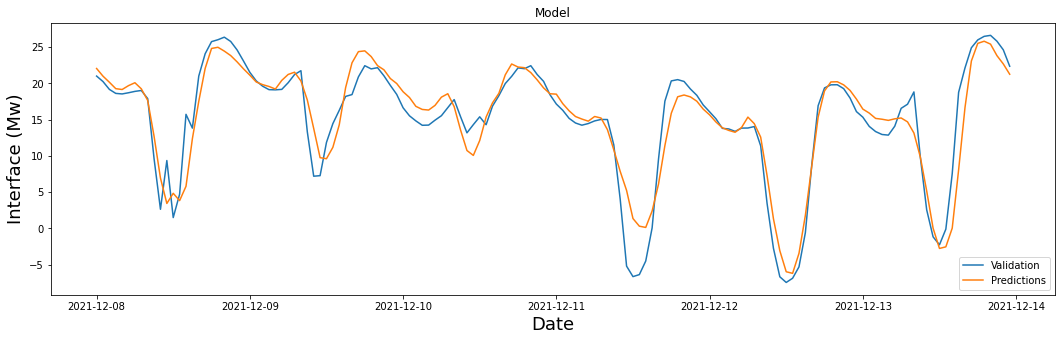

In [189]:
interface_data = plot_df.filter(['Interface'])
valid = interface_data[-x_test.shape[0]:]
valid['Predictions'] = y_pred

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.plot(valid[['Interface', 'Predictions']])
plt.legend(['Validation', 'Predictions'], loc='lower right')
plt.savefig(f'{SAVE_DIR}/model_forecast.png')
plt.show()

In [190]:
rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Interface'])**2)
rmse

0.17751314869812035

In [191]:
MAPE = np.mean(np.abs((valid['Interface'] - valid['Predictions']) / valid['Interface'])) * 100
MAPE

62.33619469288413

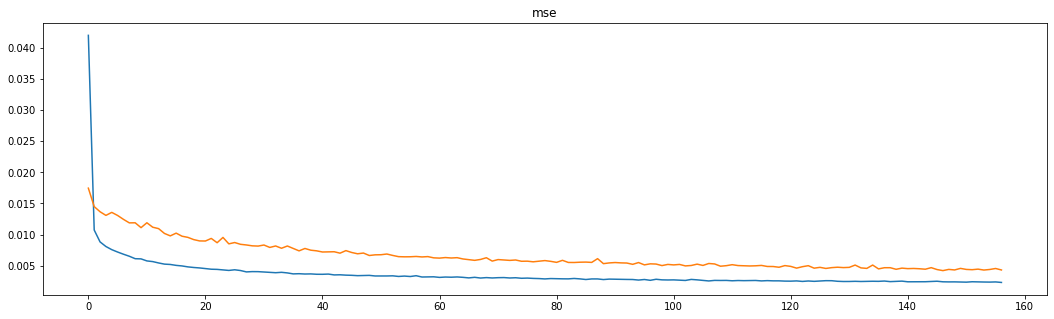

In [192]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('mse')
plt.savefig(f'{SAVE_DIR}/model_mse.png')
plt.show()

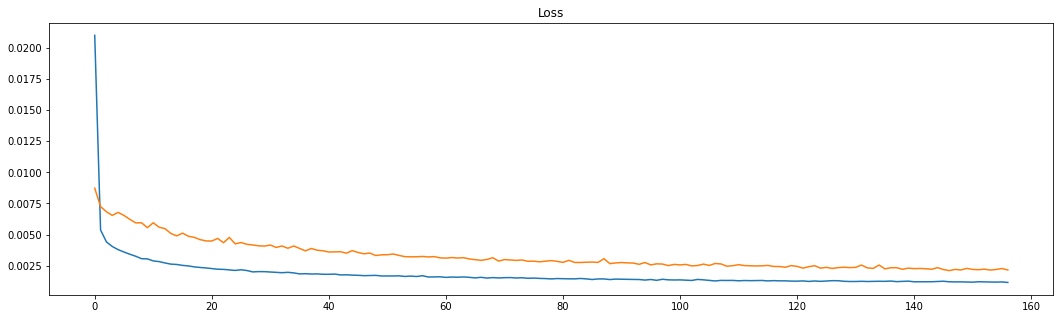

In [193]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.savefig(f'{SAVE_DIR}/model_loss.png')
plt.show()

# Forecast

In [194]:
FUTURE = 167 # Amount of hours to predict
output = []
x_forecast = np.reshape(forecast_data_[0],(1, forecast_data_[0].shape[0], forecast_data_[0].shape[1]))
series_forecast = np.reshape(forecast_series_data[0],(1, forecast_series_data[0].shape[0], forecast_series_data[0].shape[1]))

for i in range(FUTURE):
    volatility_forecast = np.reshape(forecast_volatility[i],(1, forecast_volatility[i].shape[0], forecast_volatility[i].shape[1]))
    
    y_forecast = model.predict([x_forecast, volatility_forecast, series_forecast])[0][0]
    
    # Eliminate 'Interface' data from next sequence and append predicted value instead
    # example:
    # [interface, local generation, is_workday, season_of_year] -> [local generation, is_workday, season_of_year]
    # [local generation, is_workday, season_of_year] -> [interface prediction, local generation, is_workday, season_of_year]
    pred_data = np.append(y_forecast, forecast_data_[0][i,-3:])
    pred_series = np.append(y_forecast, forecast_series_data[0][i, 1])
    
    # Append the last sequence to the next sequence and eliminate the older
    # example:
    # [1,2,3] - p1
    # [2,3, p1] - p2
    # [3, p1, p2] - p3
    x_forecast = np.vstack((forecast_data_[i,:][1:], pred_data))
    series_forecast = np.vstack((forecast_series_data[i,:][1:], pred_series))
    
    # Reshape to get a (BATCH_SIZE, 168 , NUMBER_OF_FEATURES) -> LSTM input shape
    x_forecast = np.reshape(x_forecast,(1, x_forecast.shape[0], x_forecast.shape[1]))
    series_forecast = np.reshape(series_forecast,(1, series_forecast.shape[0], series_forecast.shape[1]))
    
    output.append(y_forecast) 
    

In [195]:
forecast_prediction = y_scaler.inverse_transform(np.array(output).reshape(-1,1))

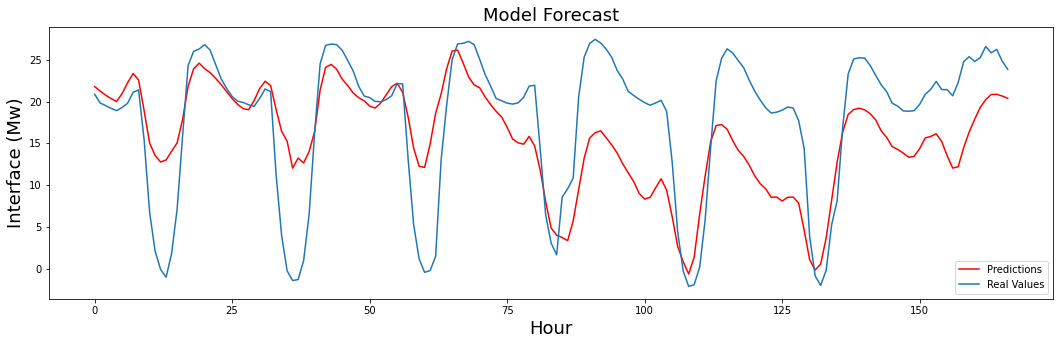

In [196]:
plt.plot(forecast_prediction, color='red')
plt.plot(forecast_data['Interface'].values[:FUTURE])
plt.savefig(f'{SAVE_DIR}/model_final_forecast.png')
plt.title('Model Forecast', fontsize=18)
plt.xlabel('Hour', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.legend(['Predictions', 'Real Values'], loc='lower right')
plt.show()

In [197]:
rmse = np.sqrt(np.mean(forecast_prediction - forecast_data['Interface'].values[:FUTURE])**2)
rmse

2.165878527302824

In [198]:
MAPE = np.mean(np.abs((forecast_data['Interface'].values[:FUTURE] - forecast_prediction) / forecast_data['Interface'].values[:FUTURE])) * 100
MAPE

450.065351577961